#### __INFO 521__: _Introduction to Machine Learning_  $\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$  Jennifer Kadowaki
---

# Estimating Redshifts using Pixel Variations in Survey Images of Ultra-Diffuse Galaxies Candidates


## Introduction to Ultra-Diffuse Galaxies
Ultra-diffuse galaxies (UDGs)--an enigmatic population of spatially-extended, low surface-brightness galaxies--were recently discovered in large numbers (~1000) near the core of the Coma Cluster (Figure 1a). Despite their low stellar masses, UDGs survive in harsh and dense environments, implying that a subset of UDGs must reside in massive dark matter halos. To date, the largest and most massive UDG known is Dragonfly 44 (DF44; Figure 1b), which is as large as the Milky Way with only 1% of its stellar population. Based on scaling relations, globular cluster counts, and velocity dispersion measurements, the halo of DF44 is estimated to be as massive as the Milky Way’s, challenging our current framework on galaxy evolution: galaxies residing in dark matter halos of this mass regime are maximally efficient, typically producing 100x more stars (Figure 2). To remedy this discrepancy, we must understand what drives star formation in dark matter halos and why UDGs deviate so far from their expected star formation efficiency. My dissertation will (1) confirm the properties (e.g., size, mass) of UDGs to verify that this discrepancy is real and (2) test both large-scale and small-scale environmental mechanisms for halting star formation in UDGs.

UDGs in Coma  | DF44 Spectra
------------- | -------------
<img src="notebook_images/coma_all.png"/> | <img src="notebook_images/df44_spectra.png"/>
**Figure 1a**: The red dots highlight the locations of UDGs in the core of the Coma Galaxy Cluster. These UDGs initially discovered from a survey conducted with the Dragonfly Telephoto Array. The left image is a composite of the Dragonfly g+r bands. A higher resolution i-band image from the Canada-France-Hawaii Telescope (CFHT) confirms the presence of these galaxies.

**Figure 1b**: DF44 is the largest known UDG to date (until I publish my next paper). van Dokkum, et al. (2015b, 2016) confirms that this galaxy is indeed as large and as massive as the Milky Way by acquiring spectroscopic measurements with the Keck II Telescope.

<img src="notebook_images/behroozi13.png" alt="Evolution of Star Formation Efficiency" style="width: 800px;" align="center"/>
**Figure 2**: *The evolution of star formation efficiency across several orders of dark matter halo mass (Behroozi, et al. 2013).* Across most redshifts, the star formation efficiency appears to peak in galaxies residing in a $10^{12} \, \mathrm{M_{\odot}}$ dark matter halo--the Milky Way's estimated dark matter halo mass. If the population of massive UDGs are as massive as the Milky Way, our current understanding of galaxy evolution suggests that they should be extremely efficient at forming stars.


**Footnote**:
$1 \, \mathrm{M_{\odot}}$ (i.e. 1 "solar mass") corresponds to the mass of our Sun. The largest Milky Way dwarfs (i.e. Large and Small Magellanic Clouds) are roughly $10^{10} \, \mathrm{M_{\odot}}$. The Milky Way is considered to be a massive galaxy at $10^{12} \, \mathrm{M_{\odot}}$. Galaxies are often found in large clusterings of galaxies (i.e. galaxy clusters) with an estimated dynamical mass of $10^{14}-10^{15} \, \mathrm{M_{\odot}}$. These environments are extremely violent due to the strong gravitational interactions with other galaxies and the presence of the intercluster medium (ICM)--the extremely hot, x-ray emitting gas existing between clustered galaxies.

## Science Motivation
__What are the drivers of star formation in the dark matter halos of massive galaxies? Are environmental mechanisms responsible for star formation quenching in UDGs?__ To understand why massive UDGs deviate two orders of magnitude from their expected star formation efficiency and to identify potential environmental mechanisms causing this extreme quenching, we must obtain statistics of the local environments of UDGs. To do so, we must find more extremely massive UDGs across environments of various densities. This will require accurate distance measurements to (1) determine whether a candidate is a true UDG by confirming its physical size and (2) properly assess the environment of the UDG.


## INFO 521 Project Goal
Our group is conducting an extensive search throughout the DECaLS, BASS, and MzLS pre-imaging surveys to find large, spatially-extended, low-surface brightness (LSB) objects. So far, we have identified ~50 LSB targets for our next observational run at the Large Binocular Telescope in January 2018. However, as demonstrated in Kadowaki, et al. (in prep), by targeting the largest UDG candiates, our samples are contaminated by small foreground objects (e.g. large dwarf galaxies in the Local Group). __To maximize our efficiency at finding the largest and most massive UDGs for future galaxy evolution and dark matter studies, we must develop an algorithm to crudely estimate the redshifts of UDG candidates from available imaging data.__ We will use the results of this algorithm to select priority targets for our upcoming observation run. This notebook presents a preliminary analysis for our initiative, using machine learning methods.


## Methodology
Our UDG candidates are in proximity to the outskirts of the Coma Cluster. As such, a true UDG will more likely be at the redshift of the cluster. This distance is roughly ~100 Mpc (~326 million light years). For context, the distance to the Coma Cluster is roughly 100x the distance to the edge of the Local Group, where some of our dwarf galaxy contaminates reside. As such, UDGs appear as featureless "blobs." Due to the sheer distance, any structures or features in the UDG will appear washed out compared to our more local contaminants. I will exploit this known feature to help us determine UDG candidates from survery images.

I will use pixel variations as a proxy for clumpiness and structure in our images.

#### Importing Packages

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import seaborn as sns
import glob as g
import os
import errno
import pandas as pd
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Turn off annoying matplotlib warning
import warnings
warnings.filterwarnings("ignore", ".*GUI is implemented.*")
warnings.filterwarnings("ignore", ".*LaTeX*")
warnings.filterwarnings("ignore", ".*clobber*")
warnings.filterwarnings("ignore", ".*Future*")

# Pretty Plot Text
plt.rcParams['savefig.facecolor'] = "1."
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)


#### File Name Convension

In [188]:
data_dir  = 'data'
im_dir    = 'images'

fits_file  = '.fits'
pdf_file   = '.pdf'
png_file   = '.png'

info_ext  = '.data'
model_ext = '_model'
sub_ext   = '_subtracted'
unsub_ext = '_unsubtracted'
mask_ext  = '_mask'
res_ext   = '_res'
hist_ext  = '_hist'
kde_ext   = '_kde'

obs_list  = []

#### Observation Class
This class stores file name information for all unique objects and observed bands.

In [91]:
class Observation:
    def __init__(self, UDG, band, info, model, sub, unsub):
        self.UDG   = UDG
        self.band  = band
        
        self.info  = info
        self.model = model
        self.sub   = sub
        self.unsub = unsub

        # Assign Values Later
        self.bkg_mean   = np.nan
        self.bkg_stdev  = np.nan
        self.gal_mean   = np.nan
        self.gal_median = np.nan
        self.gal_stdev  = np.nan
        self.kde        = []
        
        self.velocity = np.nan

        
    def get_info(self):
        return os.path.join(data_dir, self.UDG, self.band, self.info)
    
    def get_band(self):
        return self.band
    
    def get_basename(self):
        return self.get_info()[:-5]
    
    def get_bkg_mean(self):
        return self.bkg_mean
    
    def get_bkg_stdev(self):
        return self.bkg_stdev
    
    def get_gal_mean(self):
        return self.gal_mean
    
    def get_gal_median(self):
        return self.gal_median
    
    def get_gal_stdev(self):
        return self.gal_stdev
    
    def get_mask(self, mask=mask_ext, fits=fits_file):
        return self.get_basename() + mask + fits
    
    def get_model(self):
        return os.path.join(data_dir, self.UDG, self.band, self.model)
    
    def get_res(self, res=res_ext, fits=fits_file):
        return self.get_basename() + res + fits
    
    def get_sub(self):
        return os.path.join(data_dir, self.UDG, self.band, self.sub)
    
    def get_unsub(self):
        return os.path.join(data_dir, self.UDG, self.band, self.unsub)
    
    def set_bkg_mean(self, bkgmean):
        self.bkg_mean = bkgmean
        
    def set_bkg_stdev(self, bkgstdev):
        self.bkg_stdev = bkgstdev
        
    def set_gal_mean(self, galmean):    
        self.gal_mean = galmean
        
    def set_gal_median(self, galmedian):
        self.gal_median = galmedian
        
    def set_gal_stdev(self, galstdev):
        self.gal_stdev  = galstdev
        
    def set_kde(self, kde_result):
        self.kde = kde_result
        
    def set_velocity(self, vel):
        self.velocity = vel

#### Constructing New Obervation Objects based on Data Hierarchy
To run this code on the sample data provided, unpack data.zip in the same directory as this Jupyter notebook.

In [189]:
for obj_path in g.glob(data_dir + '/*'):
    
    obj = os.path.basename(obj_path)
    band_list = []
    print(obj)
    
    for band_path in g.glob(obj_path  + '/*'):
        
        band = os.path.basename(band_path)
        band_list.append(band)
        file_list = []
        print('\t',band)
        
        for file_path in g.glob(band_path + '/*'):
            
            file = os.path.basename(file_path)
            file_list.append(file)
            
            if info_ext in file_path:
                info = file
                print('\t\tINFO: ',file)

            if model_ext in file_path:
                model = file
                print('\t\tMODEL:',file)

            if sub_ext in file_path:
                sub = file
                print('\t\tSUB:  ',file)
                
            if unsub_ext in file_path:
                unsub = file
                print('\t\tUNSUB:',file)

        new_obs = Observation(obj, band, info, model, sub, unsub)
        obs_list.append(new_obs)

PU0838589
	 g
		INFO:  PU0838589_260428_g.data
		MODEL: PU0838589_260428_g_model.fits
		SUB:   PU0838589_260428_g_subtracted.fits
		UNSUB: PU0838589_260428_g_unsubtracted.fits
	 z
		INFO:  PU0838589_260428_z.data
		MODEL: PU0838589_260428_z_model.fits
		SUB:   PU0838589_260428_z_subtracted.fits
		UNSUB: PU0838589_260428_z_unsubtracted.fits
PU0914401
	 g
		INFO:  PU0914401_283036_g.data
		MODEL: PU0914401_283036_g_model.fits
		SUB:   PU0914401_283036_g_subtracted.fits
		UNSUB: PU0914401_283036_g_unsubtracted.fits
	 z
		INFO:  PU0914401_283036_z.data
		MODEL: PU0914401_283036_z_model.fits
		SUB:   PU0914401_283036_z_subtracted.fits
		UNSUB: PU0914401_283036_z_unsubtracted.fits
PU1006233
	 z
		INFO:  PU1006233_285219_z.data
		MODEL: PU1006233_285219_z_model.fits
		SUB:   PU1006233_285219_z_subtracted.fits
		UNSUB: PU1006233_285219_z_unsubtracted.fits
	 z1
		INFO:  PU1006234_285219_z.data
		MODEL: PU1006234_285219_z_model.fits
		SUB:   PU1006234_285219_z_subtracted.fits
		UNSUB: PU1006234_

### Functions for Organizing Data
The primary purpose for these functions is to keep consistent file names convensions and data hierarchy.
* create_directory(path)
* fname_split(path)
* grab_fits(directory)

In [64]:
def create_directory(path):
    
    """Creates a new directory if one does not exist.

    Args:
        path (str): Name of directory

    Returns:
        N/A

    Raises:
        AttributeError: Blahblah
        ValueError: Blahblah.
    """
    
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [65]:
def fname_split(path):
    
    """Splits a pathname into a list of strings comprimsed of the directory name,
        the basename of the file, and the file extension.

    Example:
        >>> path = 'dir/fname.ext'
        >>> fname_split('dir/fname.ext')
            ['dir', 'fname', '.ext']

    Args:
        path (str): Name of path

    Returns:
        list: List of 3 strings containing directory, basename, and extension for a file.
              If a directory is called, the list returns empty strings for the basename and extension.
    """
    
    directory = os.path.dirname(path)
    base, ext = os.path.splitext(os.path.basename(path))
    
    return [directory, base, ext]

In [66]:
def grab_fits(directory):
    
    """Lists all .fits files residing in a specified directory.
    
    Args:
        directory (str): Name of directory containing .fits files
        
    Returns:
        (:obj:`list` of :obj:`str`): List of all .fits files (str) in directory.
    """
    
    return g.glob(os.path.join(directory, "*" + fits_file))

# DATA

PU0914401 (g) | PU0914401 (z) | Spectroscopy
------------- | ------------- | ------------
<img src="notebook_images/PU0914401_g.png"/> | <img src="notebook_images/PU0914401_z.png"/> | <img src="notebook_images/PU0914401_spec.png" style="width: 325px;"/>

**Figure 3ab**: The cleaned Dark Energy Survey (DES) g- and z-band images of PU0914401. This faint galaxy (at the center of the image) was initially found by applying wavelet transformations on DES survey images to identify  diffuse, spatially-extended sources.

**Figure 3c**: The spectrum of PU0914401 clearly features several Balmer and Ca II H&K absorption lines, as well as [OII] and [OIII] emission lines. Because we can match these features to their rest-frame wavelengths, we know how fast this object is travelling away from us due to the expansion rate of the universe. In the nearby universe, this recessional velocity linearly scales with the object's redshift. (Therefore, we will use recessional velocity ($cz$) synonymously with redshift ($z$) for the remainer of the notebook.)

## Spectroscopic Data from the Large Binocular Telescope (LBT)
We obtain accurate redshifts for UDG candidates by cross-correleating its spectra (Figure 3c) with stellar templates featuring absorption lines commonly found in UDGs. The Doppler shift (i.e. velocity offset) found between the UDG spectra and stellar templates correspond to a velocity attributed to the universe's expansion rate. From Hubble's law, we can determine the distances to these candidates. Given the known angular size of the galaxies, a higher redshift would imply a larger physical size. Table 1 lists the coordinates [RA (J2000), dec (J2000)], the recessional velocity, and the resulting effective radius for each UDG candidate from Kadowaki, et al. (2017) and Kadowaki, et al. (in prep). Of the 14 objects, we sucessfully acquired redshift estimates for 12 candidates.

We will use our spectroscopic redshift measurements in the latter half of the notebook.

 OBJECT   | RA (J2000) | dec (J2000) | $cz$ (km/s) | $R_\mathrm{eff}$ (kpc)
--------- | ---------- | ----------- | ----------- | ----------------------    
DF03      | 13:02:16.5 |  28:57:17   |    10150    | 4.2
DF07      | 12:57:01.7 |  28:23:25   |    6587     | 4.3
DF08      | 13:01:30.4 |  28:22:28   |    7051     | 4.4
DF17      | 12:01:58.3 |  27:50:11   |    ----     | ---
DF30      | 12:53:15.1 |  27:41:15   |    7316     | 3.2
DF40      | 12:58:01.1 |  27:11:26   |    7792     | 2.9
PU0838589 | 08:38:58.9 |  26:04:28   |    ----     | ---
PU0914401 | 09:14:40.1 |  28:30:36   |    6558     | 4.5
PU1006233 | 10:06:23.3 |  28:52:19   |    1202     | 0.7
PU1217377 | 12:17:37.7 |  28:35:20   |    526      | 0.5
PU1221086 | 12:21:08.6 |  29:29:21   |    1287     | 2.4
PU1224081 | 12:24:08.1 |  28:05:45   |    37       | 0.04
PU1251013 | 12:51:01.3 |  27:47:53   |    6159     | 4.3
PU1304535 | 13:04:53.5 |  27:42:53   |    7333     | 4.6

## Imaging Data from the Dark Energy Camera Legacy Survery (DECaLS)

Our imaging data for objects we have observed and for candidates we will be observing are from the DESI pre-imaging surveys. For most of our targets, we have at least two bands (g-, r-, and i-bands) for each object.

### Plotting Imaging Data
All imaging data from the UDG candidates observed in the past are included in data.zip.

In [67]:
def plot_image(im, sigma=3, data=None, plot_file=None, directory=None, shape=(200,200), verbose=False, show=False):

    """ Plots imaging data to a .pdf file.
    If data is not specified, data is acquired by reading in im. Otherwise, the data is written out to im.
    Plots data and writes out displayed image to plot_file in directory. If plot_file is not specified,
    the plot_file is taken from the basename of im with extension '.pdf'. If directory is not specified,
    the plot is written out to a new subdirectory 'images'.
    
    Args:
        im (str): Name of .fits file for (1) reading & importing data or (2) writing out data.
        
        data (:obj:`nd.array`, optional):
            Array containing imaging data. If set to None, the data is acquired by reading it from im,
            a pre-existing .fits file. If it contains an array, the data is written out to im.
        
        pdf_file (str): Name of .pdf file to display data.
        
        directory (str): Name of directory to save pdf_file.
        
    Returns:
        data (float).
        
    """
    
    d, b, e = fname_split(im)
    
    if directory == None:
        directory = d
        im_directory = os.path.join(d, im_dir)
    else:
        im_directory = os.path.join(directory, im_dir)
        
    create_directory(directory)
    create_directory(im_directory)
    
    if plot_file == None:
        plot_file = os.path.join(im_directory, b + pdf_file)

        
    if data == None:
        if verbose: print("\nReading", im, ".")
        data = fits.getdata(im)
        
        if data.shape != shape:
            data = data[0:shape[0],0:shape[1]]
            hdu = fits.PrimaryHDU(np.array(data))
            hdu.writeto(im, clobber=True)
            
    else:
        im = os.path.join(directory, b + fits_file)
        if verbose: print("\nWriting", im, ".")
        hdu = fits.PrimaryHDU(np.array(data[0:shape[0],0:shape[1]]))
        hdu.writeto(im, clobber=True)
    
    
    mean  = np.mean(data)
    std  = np.std(data)
    
    plt.clf()
    plt.figure(figsize=(8,8))
    
    plt.xlabel(r"x (Pixels)")
    plt.ylabel(r"y (Pixels)")
    plt.title(r"$\mathrm{}$".format("{" + b.replace("_","\_") + "}"))

    plt.imshow(data, interpolation='none', aspect='equal', cmap='inferno', vmin=mean-sigma*std, vmax=mean+sigma*std)
    plt.colorbar()
    ax = plt.gca()
    ax.grid(color='k', linestyle='-', linewidth=0.5)
    
    if verbose: print("Writing", plot_file, ".")
    plt.savefig(plot_file, format='pdf', bbox_inches='tight', dpi=72)
    plt.savefig(plot_file.replace(pdf_file, png_file), format='png', bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
    
    return data

#### Plots of all Observed UDG Candidates in Available DES Survey Bands with their Model & Residual Images

In [11]:
for obs in obs_list:
    
    data_unsub = plot_image(obs.get_unsub(), sigma=2)
    data_model = plot_image(obs.get_model(), sigma=10)
    data_ures  = plot_image(obs.get_res(), data=data_unsub-data_model, sigma=1)

## GALFIT Models & Residual Images
Each of the original images were fed into GALFIT--an astronomical software used to model and extract galaxies. The models were fit with parameters characterizing the effective radii (i.e. size), brightness, and sersic index (i.e. concentration of density profile) for each target.

The residual image is the difference between the original image and the GALFIT model. **We use the residual image to determine clumpiness via pixel intensity variations.**


|       | PU0838589 (g)| PU0838589 (z) | PU0914401 (g) | PU0914401 (z) | PU1006233 (z) | PU1006233 (z) |
| :---- | :----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| ORIG  | <img src="data/PU0838589/g/images/PU0838589_260428_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU0838589/z/images/PU0838589_260428_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU0914401/g/images/PU0914401_283036_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU0914401/z/images/PU0914401_283036_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1006233/z/images/PU1006233_285219_z_unsubtracted.png" style="width: 150px;"/> |  <img src="data/PU1006233/z1/images/PU1006234_285219_z_unsubtracted.png" style="width: 150px;"/> | 
| MODEL | <img src="data/PU0838589/g/images/PU0838589_260428_g_model.png" style="width: 150px;"/> | <img src="data/PU0838589/z/images/PU0838589_260428_z_model.png" style="width: 150px;"/> | <img src="data/PU0914401/g/images/PU0914401_283036_g_model.png" style="width: 150px;"/> | <img src="data/PU0914401/z/images/PU0914401_283036_z_model.png" style="width: 150px;"/> | <img src="data/PU1006233/z/images/PU1006233_285219_z_model.png" style="width: 150px;"/> |  <img src="data/PU1006233/z1/images/PU1006234_285219_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU0838589/g/images/PU0838589_260428_g_res.png" style="width: 150px;"/> | <img src="data/PU0838589/z/images/PU0838589_260428_z_res.png" style="width: 150px;"/> | <img src="data/PU0914401/g/images/PU0914401_283036_g_res.png" style="width: 150px;"/> | <img src="data/PU0914401/z/images/PU0914401_283036_z_res.png" style="width: 150px;"/> | <img src="data/PU1006233/z/images/PU1006233_285219_z_res.png" style="width: 150px;"/> | <img src="data/PU1006233/z1/images/PU1006234_285219_z_res.png" style="width: 150px;"/> |



|       | PU1217377 (g)| PU1217377 (r) | PU1217377 (z) | PU1221086 (z) | PU1224081 (g) | PU1224081 (r) | PU1224081 (z) |
| :---- | :----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |  :-----------: |
| ORIG  | <img src="data/PU1217378/g/images/PU1217378_283521_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1217378/r/images/PU1217378_283521_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1217378/z/images/PU1217378_283521_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1221086/z/images/PU1221086_292920_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1224081/g/images/PU1224081_280545_g_unsubtracted.png" style="width: 150px;"/> |  <img src="data/PU1224081/r/images/PU1224081_280545_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1224081/z/images/PU1224081_280545_z_unsubtracted.png" style="width: 150px;"/> |
| MODEL | <img src="data/PU1217378/g/images/PU1217378_283521_g_model.png" style="width: 150px;"/> | <img src="data/PU1217378/r/images/PU1217378_283521_r_model.png" style="width: 150px;"/> | <img src="data/PU1217378/z/images/PU1217378_283521_z_model.png" style="width: 150px;"/> | <img src="data/PU1221086/z/images/PU1221086_292920_z_model.png" style="width: 150px;"/> | <img src="data/PU1224081/g/images/PU1224081_280545_g_model.png" style="width: 150px;"/> |  <img src="data/PU1224081/r/images/PU1224081_280545_r_model.png" style="width: 150px;"/> | <img src="data/PU1224081/z/images/PU1224081_280545_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU1217378/g/images/PU1217378_283521_g_res.png" style="width: 150px;"/> | <img src="data/PU1217378/r/images/PU1217378_283521_r_res.png" style="width: 150px;"/> | <img src="data/PU1217378/z/images/PU1217378_283521_z_res.png" style="width: 150px;"/> | <img src="data/PU1221086/z/images/PU1221086_292920_z_res.png" style="width: 150px;"/> | <img src="data/PU1224081/g/images/PU1224081_280545_g_res.png" style="width: 150px;"/> |  <img src="data/PU1224081/r/images/PU1224081_280545_r_res.png" style="width: 150px;"/> | <img src="data/PU1224081/z/images/PU1224081_280545_z_res.png" style="width: 150px;"/> |

**Figure 4**: A subset of observed UDG candidates with known spectroscopic redshifts.

__Tow Row__: The cleaned Dark Energy Survey (DES) images of UDG candidates. We discovered these faint galaxies (at the center of the image) by applying wavelet transformation on DES survey images to identify any diffuse, spatially-extended sources.

__Center Row__: The galaxy models were created using galfit, a common astronomy software used to estimate key galaxy model parameters.

__Bottom Row__: The difference image is the residual between the cleaned DES image and the model of the UDG. The model does a decent job at subtracting the overall profile of the galaxy. Any remaining structure within the difference image will be used to estimate redshift.

# Separating the UDG Candidate from the Background
Like most astronomical objects, there's no hard boundary between where the object starts and ends. (e.g. Where is the boundary of the our atmosphere? It's hard to define where it "stops.")

We define the half-light radius--a commonly used metric in extragalactic astronomy--as the radius which contains half of the object's light. To define this boundary, we typicaly use a true astronomical image. However, due to contamination from background objects (e.g. the bright source in the bottom left corner), we will use the model image (center) for the purpose of this project. The model contains a uniform background and a smooth sersic profile for the galaxy.

In [68]:
def background_statistics(data, percent=40, plot=True, verbose=False):
    
    """Naively estimates the background statistics from model image.
    This algorithm assumes that any pixel value above some percentile (percent) has some light
    contribution from diffuse UDG candidates or other astronomical contaminants, as opposed to
    background noise from pixel-to-pixel variations. The method estimates the mean and standard
    deviation in pixel intensities within the identified background, primarily for the use to
    create more sophisticated object masks.
    
    
    Args:
        data (nd.array): Input image assumed to be a 2D array.
        
        percent (float): Percentile value assumed to be [0,100). All pixel intensities that
            fall below this percentile threshold is assumed to be the background.
            
        plot (bool): Flag to create a plot of the background mask.
        
    Returns:
        bkg_mean (float):  Mean value of background region.
        
        bkg_stdev (float): Standard deviation of the background region.
        
    """
    
    # Quick & Unsophisticated Statistics of UDG Candidate Models
    mini  = np.min(data)    # Min Value in the Model
    maxi  = np.max(data)    # Max
    mean  = np.mean(data)   # Mean
    stdev = np.std(data)    # Standard Deviation of Pixel Values

    if verbose: print("Global Image\n\tMEAN: ", mean, "\n\tSTD:  ", stdev, "\n\tMIN:  ", mini, "\n\tMAX:  ", maxi)


    # Image Statistics on Isolated Background
    bkg_mask  = np.array(data < np.percentile(data, percent))
    bkg_mean  = np.mean(data[bkg_mask])
    bkg_stdev = np.std(data[bkg_mask])
    if verbose: print("Background\n\tMean: ", bkg_mean, "\n\tSTD:  ", bkg_stdev)
    
    
    if plot:
        plot_bm = data * 1.
        plot_bm[~bkg_mask] = np.nan
        
        plt.figure(figsize=(5,5))
        plt.title("Background Statistics Region")
        plt.imshow(plot_bm, interpolation='none', aspect='equal', cmap='inferno')
        plt.colorbar()
        plt.show()
    
    
    return bkg_mean, bkg_stdev 

In [48]:
def half_light_mask(data, bkg_mean, file, percent=70, plow=0, phigh=100, threshold=0.001, plot=True, verbose=False):
    
    """Computes the half-light radius
    
    
    Args:
        data (nd.array): Input image assumed to be a 2D array.
        
        mean (float):  Mean value of background region.
        
        percent (float): Percentile value assumed to be [0,100). All pixel intensities that
            fall below this percentile threshold is assumed to be the background.
            
        plot (bool): Flag to create a plot of the background mask.
        
        threshold (float): Increment and Precision of Half-light Radii
        
    Returns:
        
        stdev (float): Standard deviation of the background region.
        
    """
    data_nobkg = data - bkg_mean
    data_mask  = np.array(data_nobkg > np.percentile(data_nobkg, percent))
    #print ("\nPercentile:", percent)
    
    # STATISTICS INSIDE MASK
    in_flux  = np.sum(data_nobkg[data_mask])    # Total Flux of Background-Subtracted Galaxy
    in_mean  = np.mean(data_nobkg[data_mask])   # Mean of Background-Subtracted Galaxy
    in_stdev = np.std(data_nobkg[data_mask])    # StDev of Background-Subtracted Galaxy
    in_area  = np.sum(data_mask)                # Pixels Contained in Galaxy
    #print("Interior\n\tFlux: ", in_flux, "\tMean: ", in_mean, "\tRMS:  ", in_stdev, "\tArea:  ", in_area)
    
    # STATISTICS OUTSIDE MASK
    ext_flux  = np.sum(data_nobkg[~data_mask])   # Total Flux Outside of the Background-Subtracted Galaxy
    ext_mean  = np.mean(data_nobkg[~data_mask])  # Mean Outside of the Background-Subtracted Galaxy
    ext_stdev = np.std(data_nobkg[~data_mask])   # StDev Outside of the Background-Subtracted Galaxy
    ext_area  = np.sum(~data_mask)               # Pixels Contained Outside of the Galaxy
    #print("Exterior\n\tFlux: ", ext_flux, "\tMean: ", ext_mean, "\tRMS:  ", ext_stdev, "\tArea:  ", ext_area)
    
    if in_flux/ext_flux-1 > threshold:
        return half_light_mask(data, bkg_mean, file, percent + (phigh-percent)/2, plow=percent, phigh=phigh,   threshold=threshold, plot=plot)
    elif ext_flux/in_flux-1 > threshold:
        return half_light_mask(data, bkg_mean, file, percent - (percent-plow)/2., plow=plow,    phigh=percent, threshold=threshold, plot=plot)
    else:
        if verbose:
            print ("\nPercentile:   ", percent)
            print("Interior\n\tFlux: ", in_flux, "\n\tMean: ", in_mean, "\n\tRMS:  ", in_stdev, "\n\tArea: ", in_area)
            print("Exterior\n\tFlux: ", ext_flux, "\n\tMean: ", ext_mean, "\n\tRMS:  ", ext_stdev, "\n\tArea: ", ext_area)


        plot_in = data * 1.
        plot_in[~data_mask] = np.nan    

        fig = plt.figure(figsize=(10, 10))
        plt.title("Half-Light Radii Mask")
        plt.xlabel(r"x (Pixels)")
        plt.ylabel(r"y (Pixels)")

        plt.imshow(plot_in, interpolation='none', aspect='equal', cmap='inferno')
        plt.colorbar()
        plt.savefig(file.replace(pdf_file, png_file), format='png', bbox_inches='tight')

        if plot: plt.show()
        plt.close()

    hdu = fits.PrimaryHDU(data_mask * 1.)
    hdu.writeto(file, clobber=True)
    
    return data_mask, percent

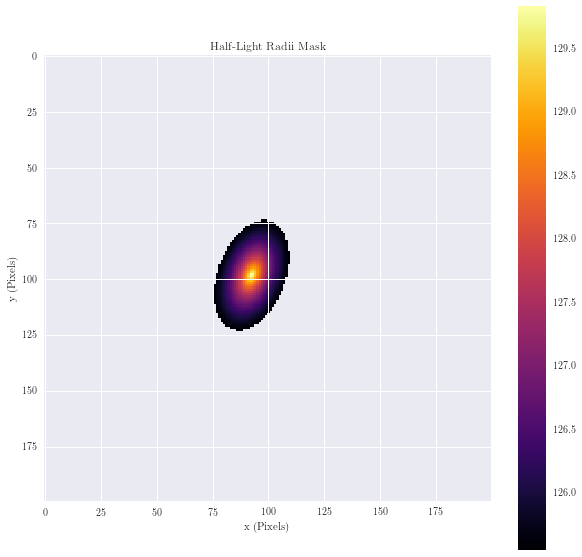

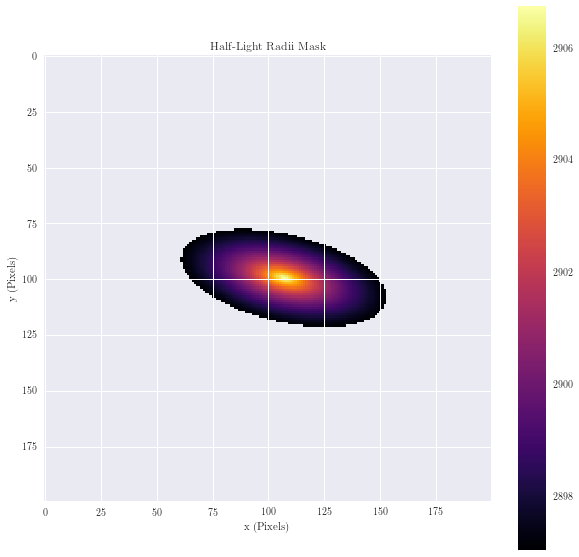

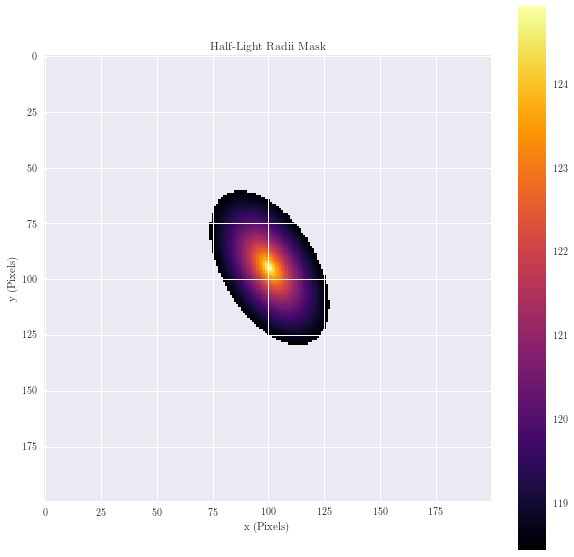

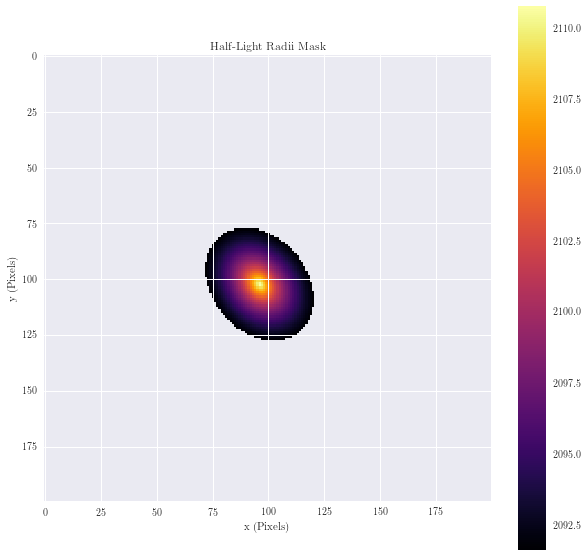

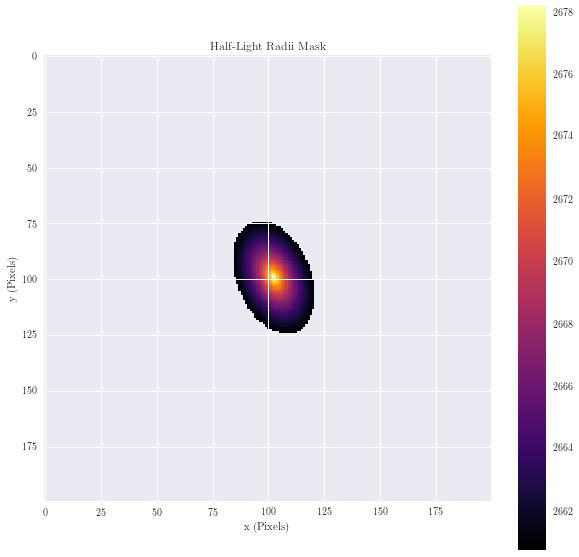

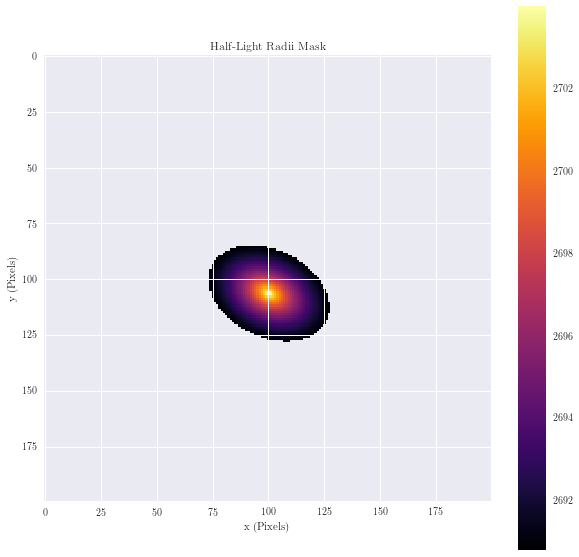

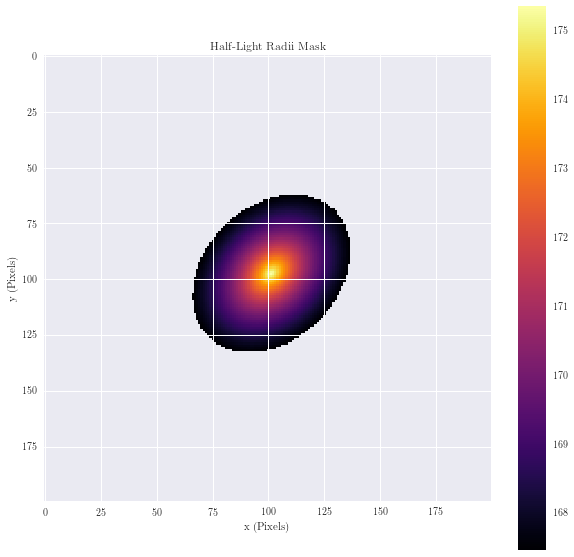

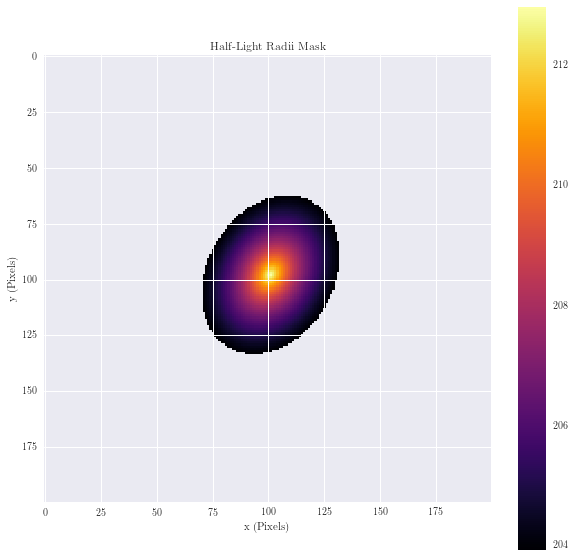

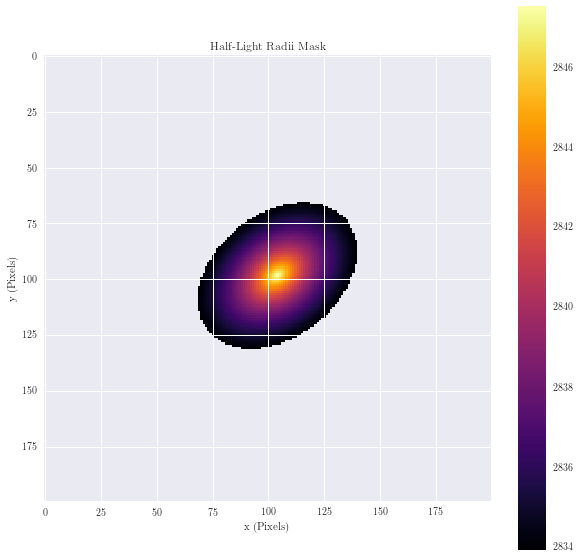

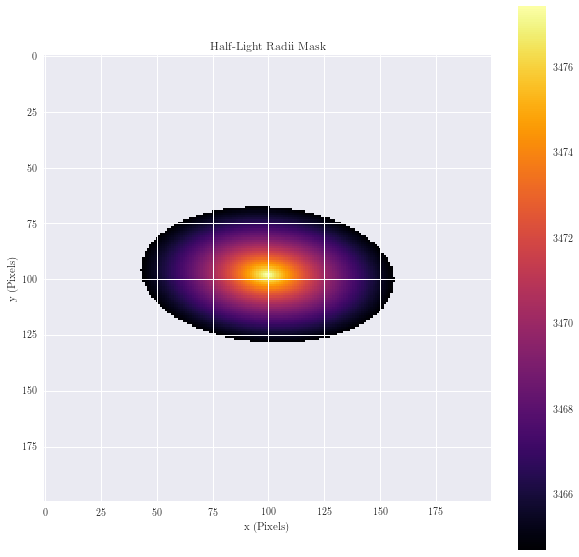

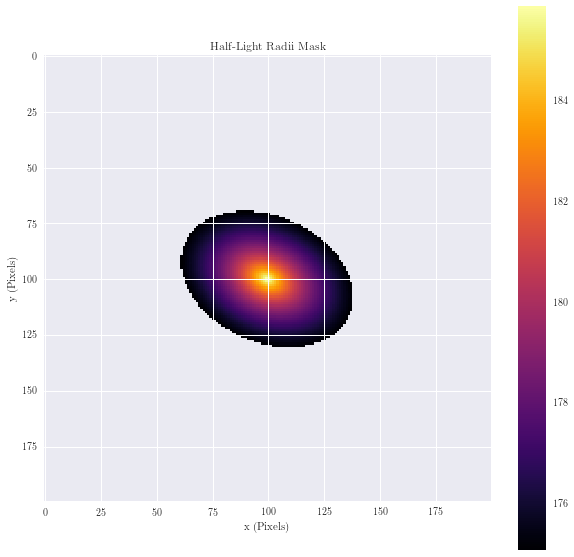

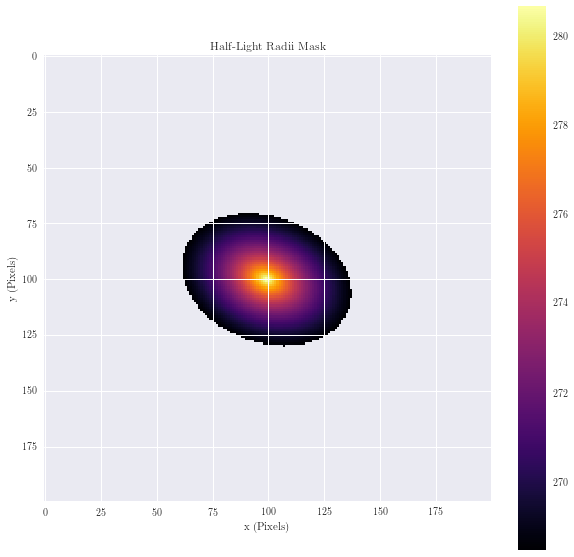

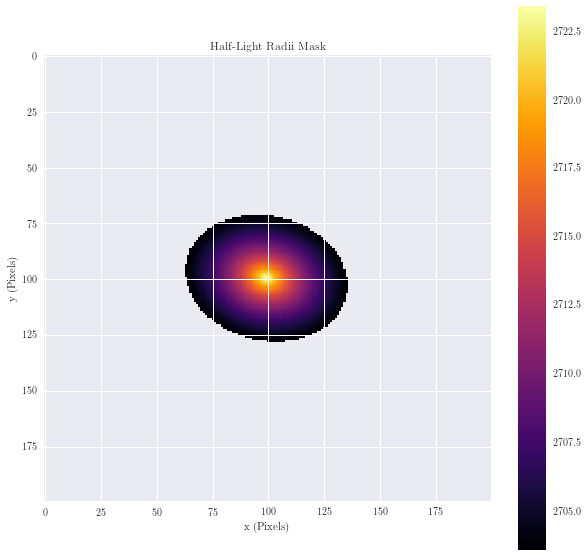

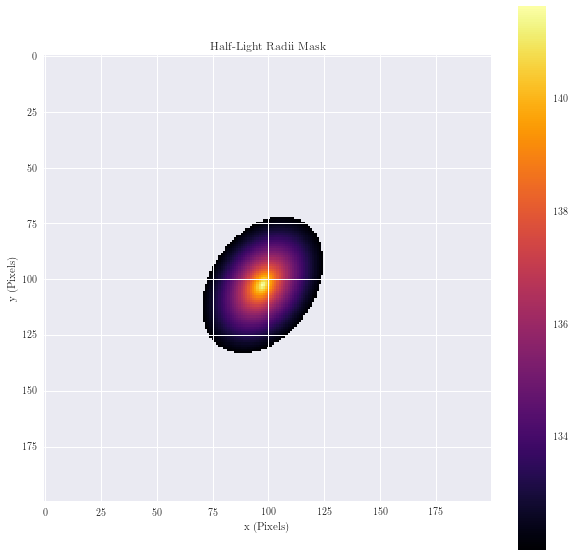

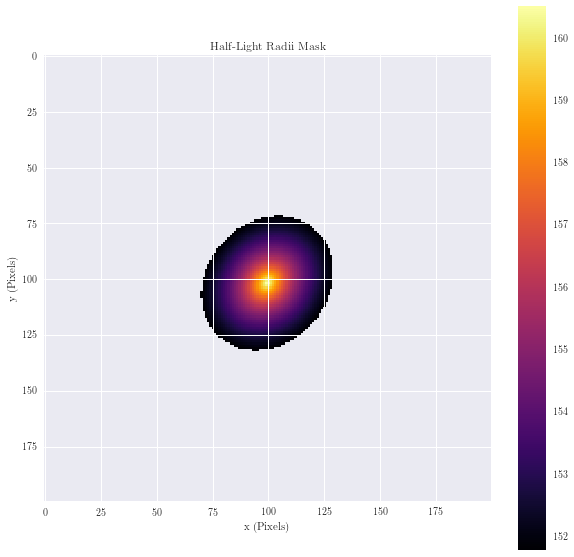

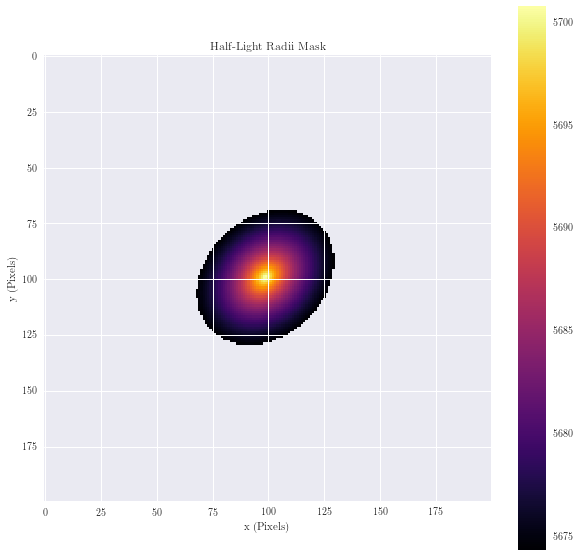

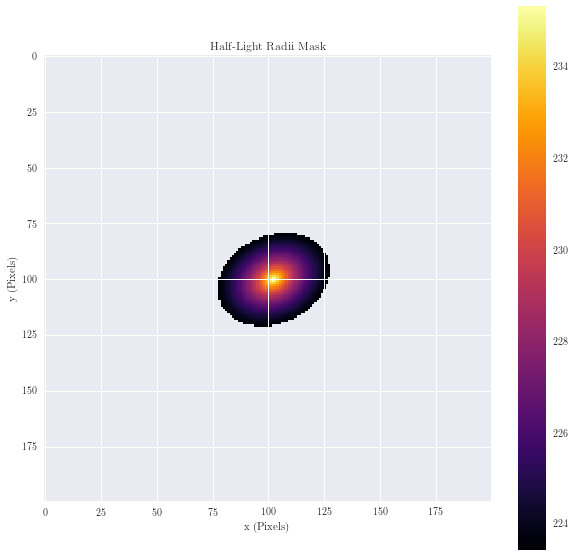

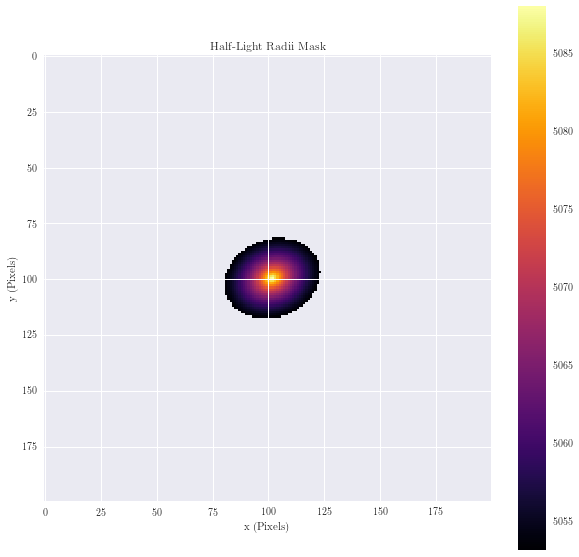

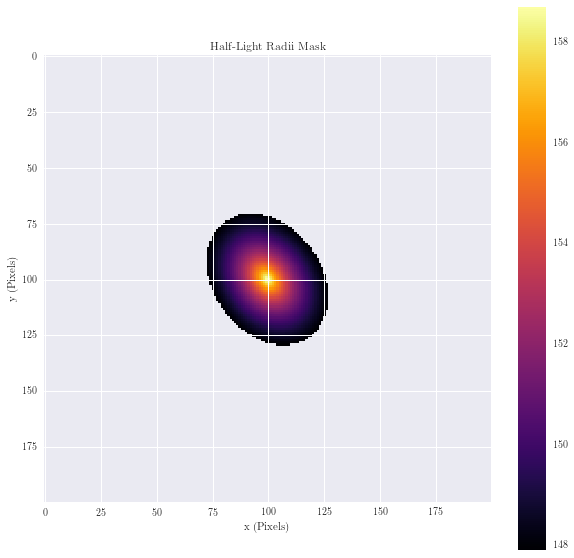

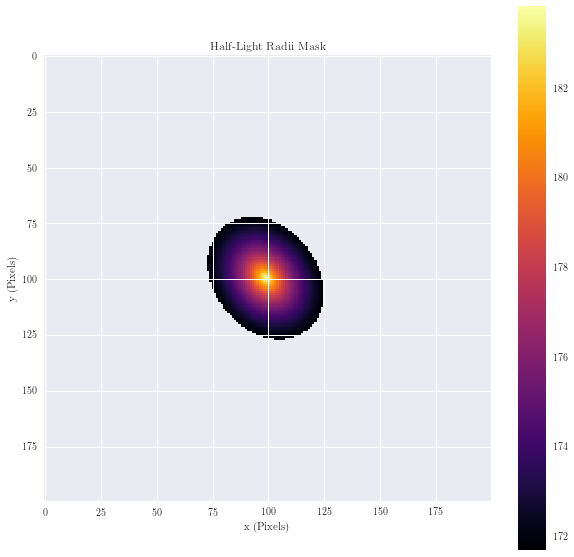

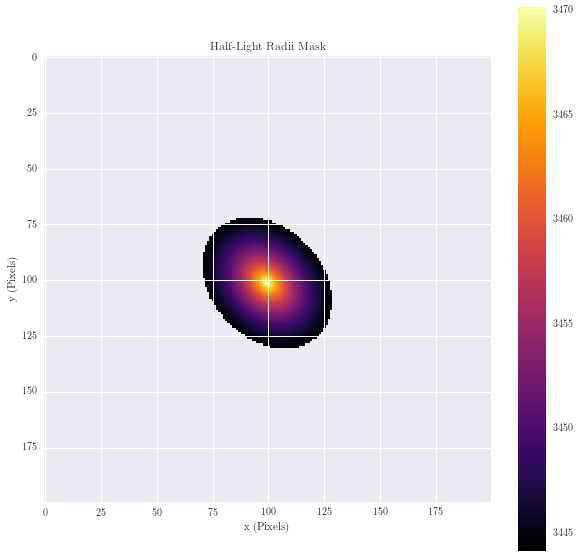

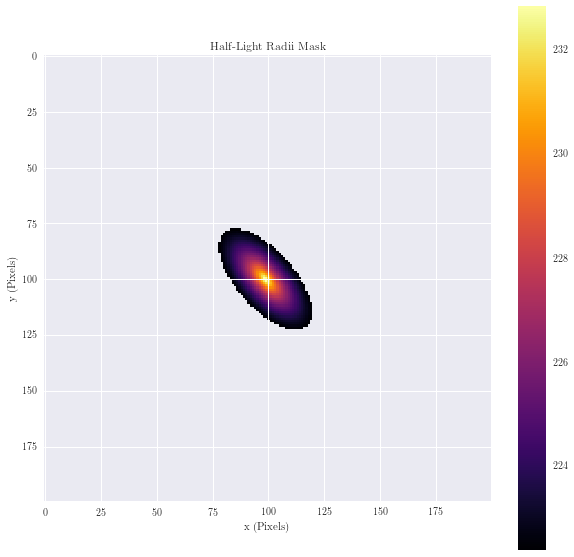

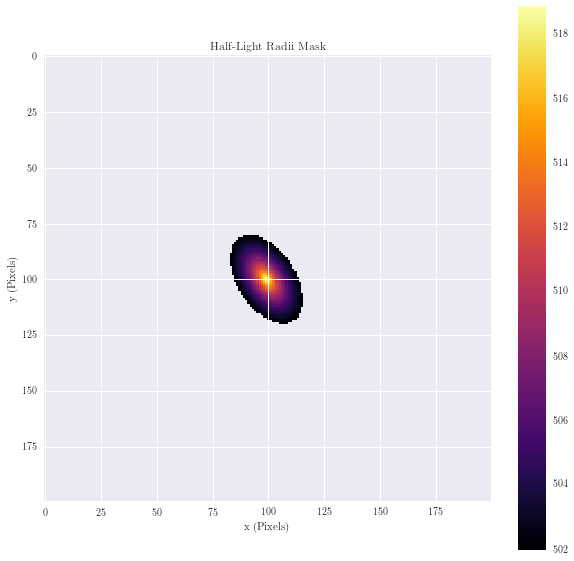

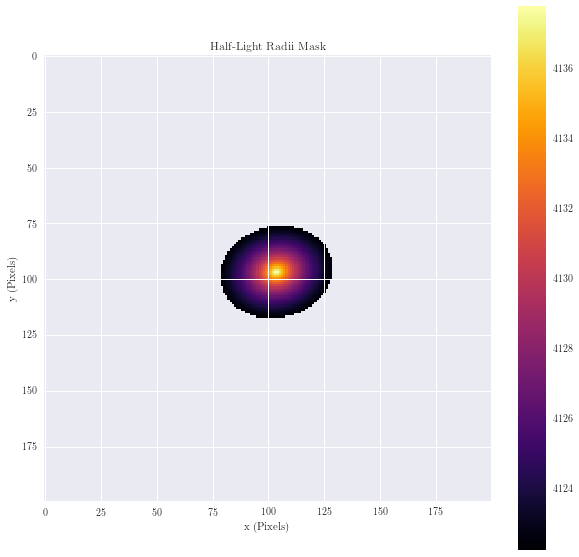

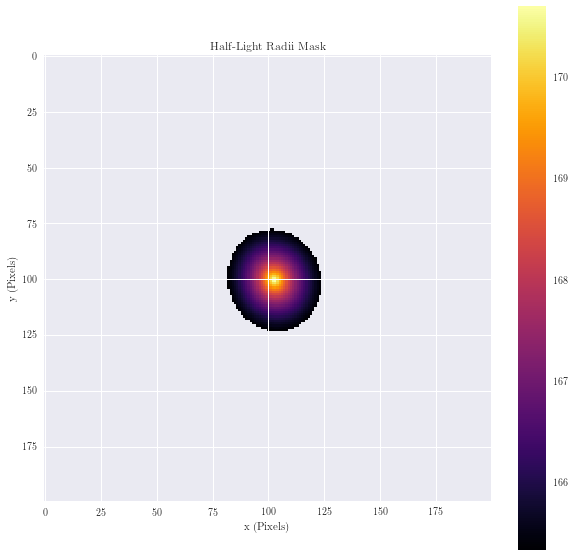

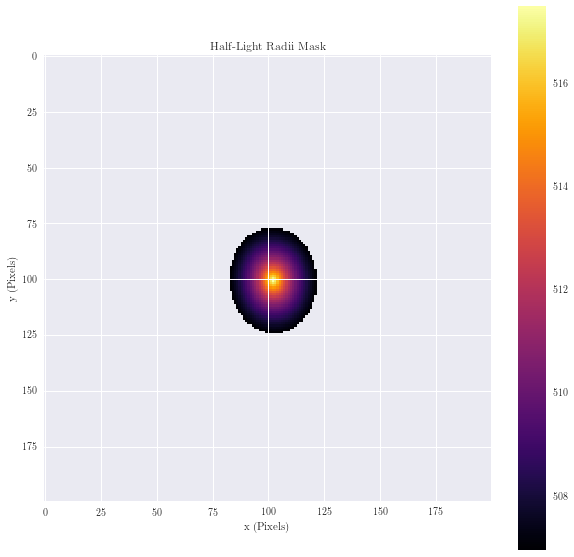

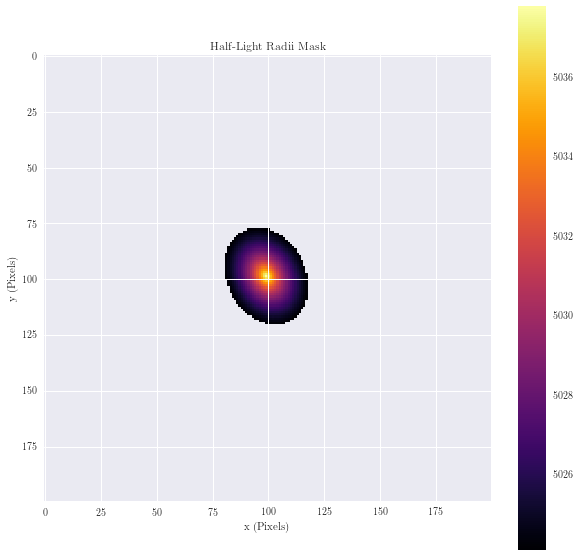

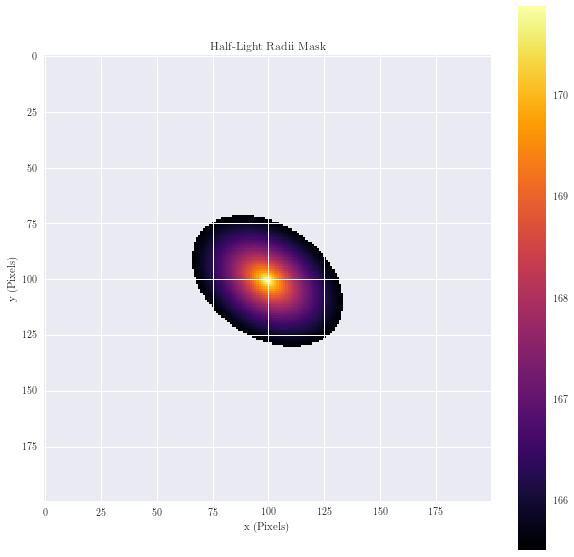

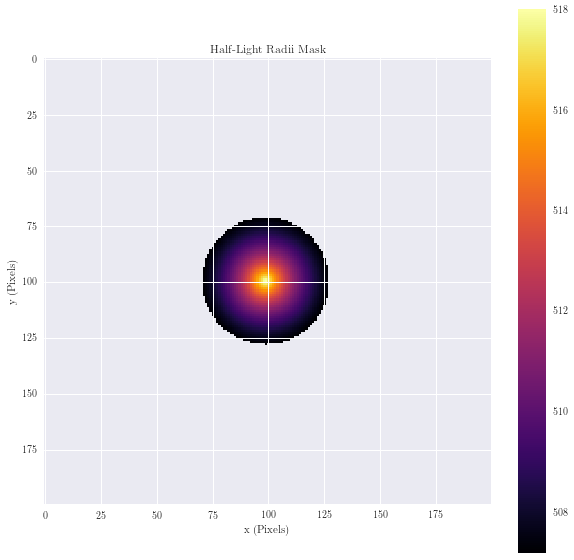

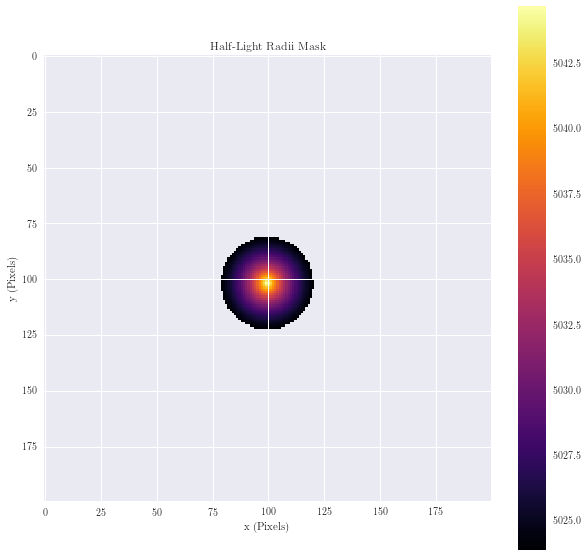

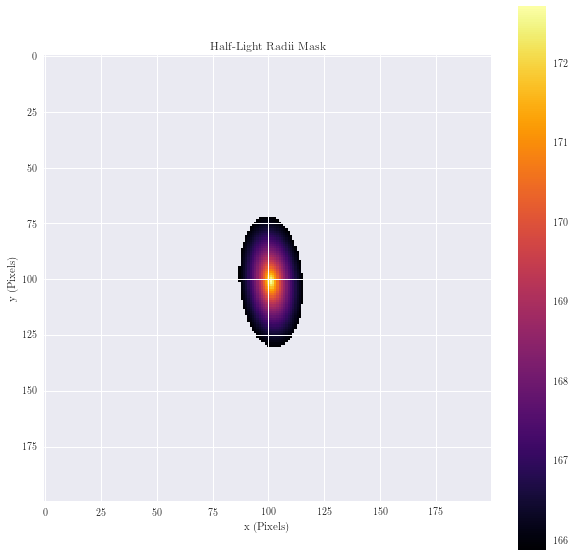

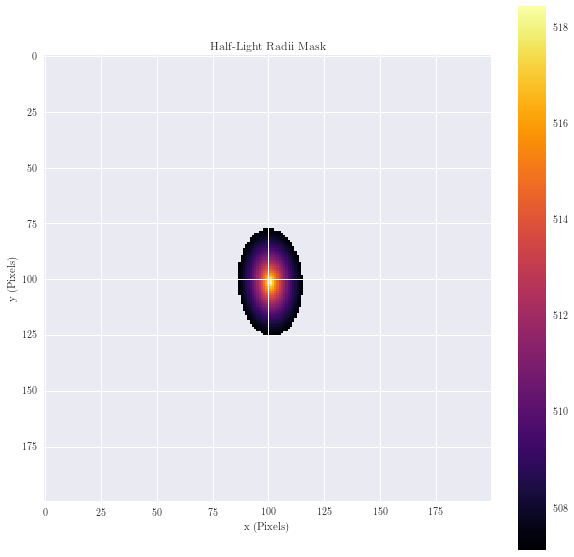

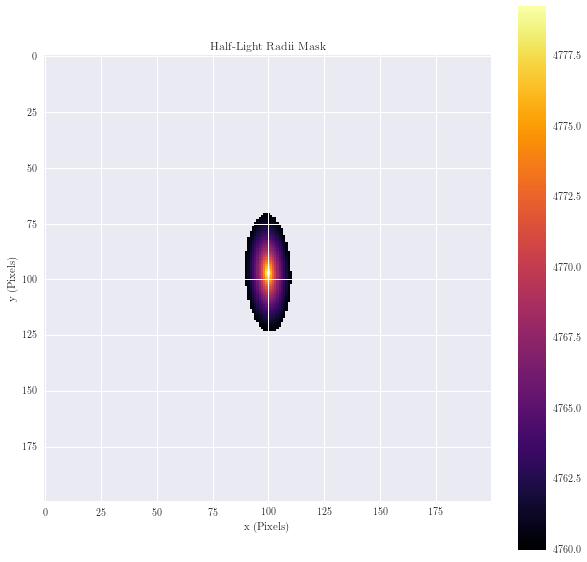

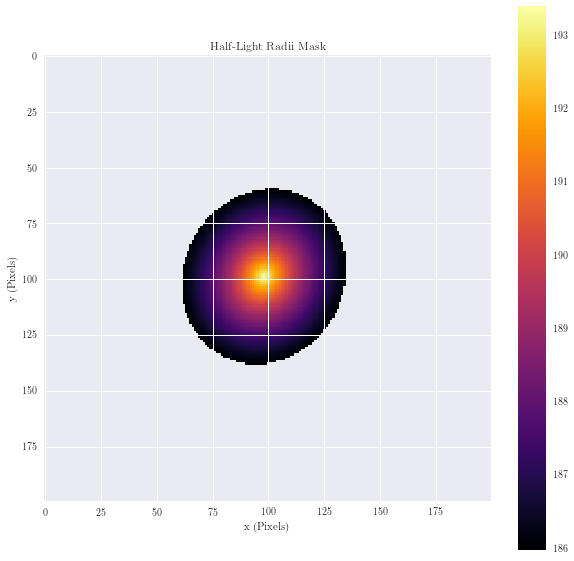

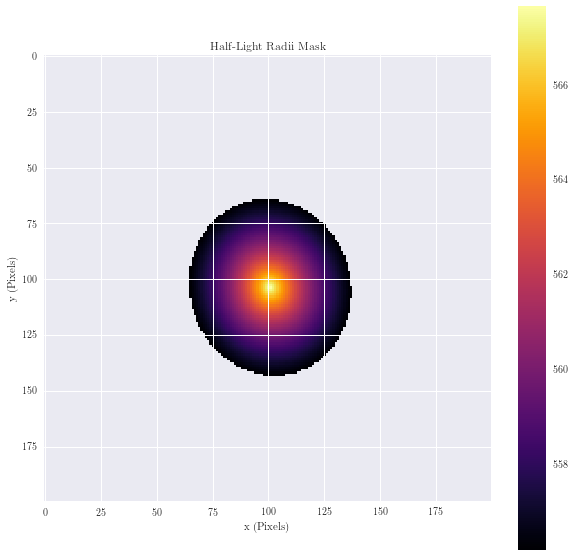

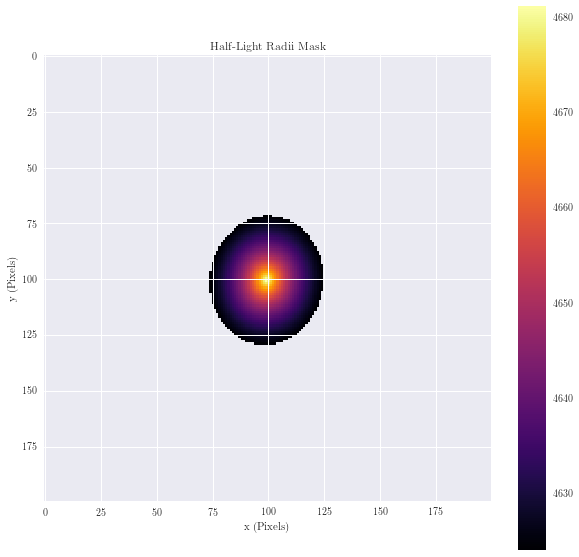

In [191]:
for obs in obs_list:

    model = fits.getdata(obs.get_model())
    
    bkg_mean, bkg_stdev = background_statistics(model, plot=False)
    obs.set_bkg_mean(bkg_mean)
    obs.set_bkg_stdev(bkg_stdev)
    
    hlr_mask, percentile = half_light_mask(model, bkg_mean, obs.get_mask(), percent=90, plot=True)

The plots above depict the half-light radius mask for all previously observed UDGs. We will analyze pixel variations in the regions defined by these masks.

# Characterizing Pixel Intensity Variations
See $\S6$: "Searching for Structure in Point Data" from <u> Statistics, Data Mining, and Machine Learning in Astronomy </u> by Ivezic, Connolly, VanderPlas, and Gray.

## Kernel Density Estimation
Given a sample, Kernel Density Estimation (KDE) is a non-parametric, smoothing technique used to construct an estimate for the underlying probability distribution used to generate the sample data. KDE is mathematically defined as

<center> $\hat{f}_N(x) = \frac{1}{h^D} \sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right)$, </center>

where $K(u)$ is the kernel and $h$ is the bandwidth (i.e. size of kernel). KDE estimates the underlying distribution by taking a weighted mean of the sample data, using the kernel fuction as the weight.


### Using a Gaussian Kernel
We use the Gaussian kernel:

<center> $K(u) = \frac{1}{(2\pi)^{D/2}} \exp \left(-u^2/2 \right)$, </center>

where $D$ is the number of dimensions (i.e. 1 in this case), and $u = d(x, x_i)/h$. 

I chose a Gaussian kernel for the KDE since the underlying distribution of pixel intensities should be roughly Gaussian, due to the Central Limit Theorem. More specifically, the background fluctuation is roughly Gaussian. In low-surface brightness astronomy, the background is the dominant source of the flux.

KDE can easily be modified to use other kernels, including but not limited to 'exponential,' 'tophat,' and 'epanechnikov' kernels. Due to the relatively large number of pixels available, the KDE results using all kernels vary minimally. To plot the results from other kernels, include each kernel keyword into the "kernel_list" in the code below.

The bandwidth choice has a greater impact on KDE as opposed to the kernel choice when large number of pixels are available. Cross-validation can be used to optimize for the bandwidth, which will be implemented in the future. Here, I have determined the best KDE bandwidth by eye for each band. 


### Implementing a Gaussian KDE on Pixel Intensity Variations
Below follows the implementation of Scikit-Learn's 1D Kernel Density Estimation Example, which can be found here:
http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

In [115]:
def plot_kde(data, mask=None, band='g', background=None, file=None, verbose=False):
    
    kernel_list = ['gaussian'] # Add Other Kernels: 'exponential', 'tophat', 'epanechnikov', 'gaussian'
    
    if mask==None:
        mask = np.ones(data.shape, dtype=bool)


    # IMAGE WITH HALF-LIGHT RADIUS MASK    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax1.set_title("Half-Light Radii Mask")
    ax1.set_xlabel(r"x (Pixels)")
    ax1.set_ylabel(r"y (Pixels)")
    
    image = 1. * data
    image[~mask] = np.nan
    img = plt.imshow(image, interpolation='none', aspect='equal', cmap='inferno')
    plt.colorbar(img, ax=ax1)
    
    
    
    # INTENSITY HISTOGRAM OF MASKED IMAGES
    ax2 = fig.add_subplot(122)
    ax2.set_facecolor('white')
    ax2.set_title(r"Pixel Variation")
    ax2.set_xlabel(r"Pixel Intensity (ADU)")
    ax2.set_ylabel(r"PDF")
    
    # Plots Gaussian.
    arr = np.sort(data[mask].reshape((np.sum(mask),1)))
    x = np.linspace(np.min(arr), np.max(arr), arr.size)[:, np.newaxis]
        
    if background != None:
        mu, sigma = norm.fit(data[mask])
        gauss = norm.pdf(x, mu, sigma)
        plt.plot(x, gauss, color='g')
    
    # Plots mean, 1-sigma, 2-sigma, and 3-sigma.
    mu, sigma = norm.fit(arr)  
    plt.axvline(x=mu, linestyle="-", color='g', alpha=0.5)
    plt.axvline(x=mu+sigma, linestyle="-.", color='g', alpha=0.5)
    plt.axvline(x=mu-sigma, linestyle="-.", color='g', alpha=0.5)
    plt.axvline(x=mu-2*sigma, linestyle="--", color='g', alpha=0.5)
    plt.axvline(x=mu+2*sigma, linestyle="--", color='g', alpha=0.5)
    plt.axvline(x=mu-3*sigma, linestyle=":", color='g', alpha=0.5)
    plt.axvline(x=mu+3*sigma, linestyle=":", color='g', alpha=0.5)
    if verbose: print("\n\tmu:",mu,"\n\tsigma:", sigma,"\n\tMedian:", np.median(arr))

    # Plots Histogram of Masked Data.
    ax2.hist(data[mask], bins=30, normed=True, alpha=0.3)
    #ax.scatter(arr, np.zeros((np.sum(mask),1)), c='r', s=0.1)
    
    # Plots the KDE Distribution.
    for kernel in kernel_list:
        if any([band == 'z',band=='z1']):
            kde = KernelDensity(kernel=kernel, bandwidth=1.75).fit(arr)
        if band == 'r':
            kde = KernelDensity(kernel=kernel, bandwidth=0.85).fit(arr)
        if band == 'g':
            kde = KernelDensity(kernel=kernel, bandwidth=0.7).fit(arr)

        y = np.exp(kde.score_samples(x))
        ax2.plot(x[:, 0], y, '-', c='r', label="kernel = '{0}'".format(kernel))

    
    ax2.legend(loc='best')
    if file != None:
        plt.savefig(file, format='png', bbox_inches='tight')
    plt.show()
    
    return x,y

PU0838589


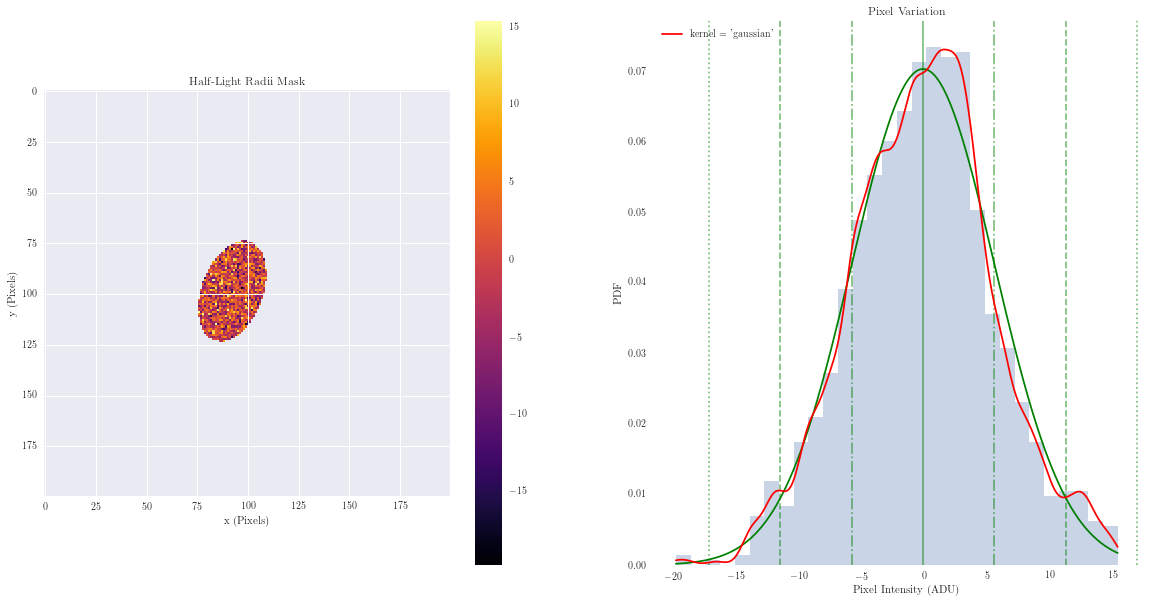

PU0838589


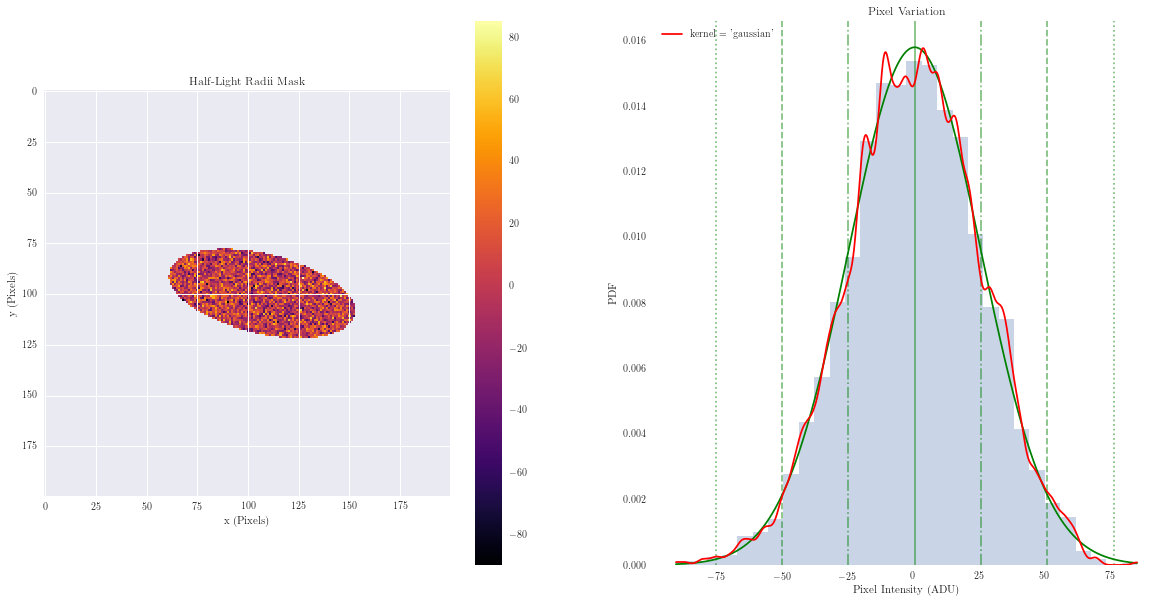

PU0914401


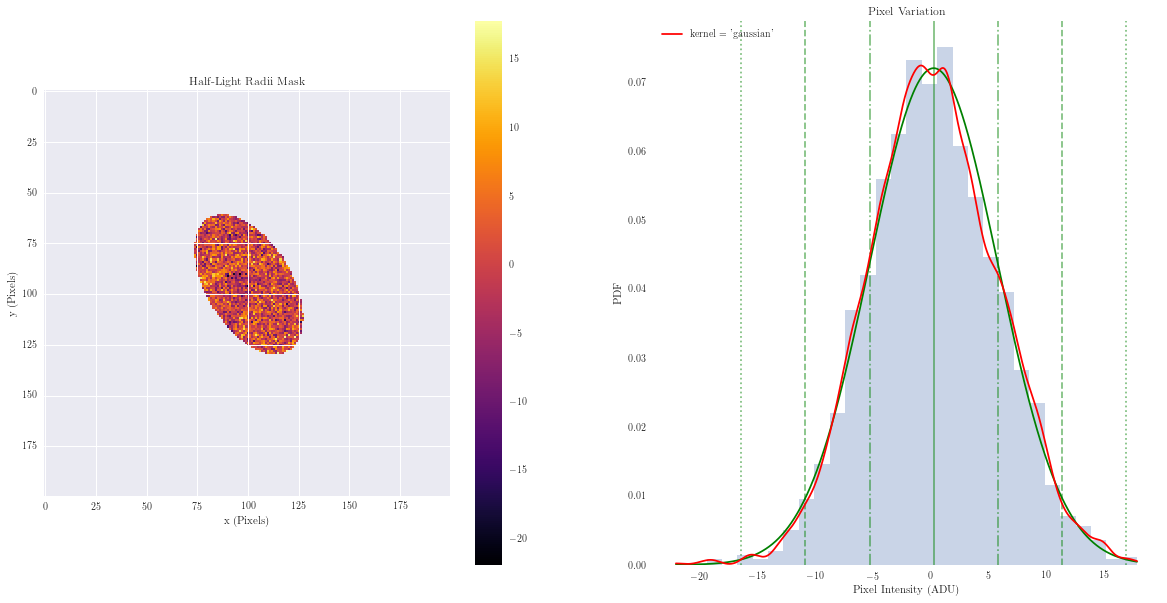

PU0914401


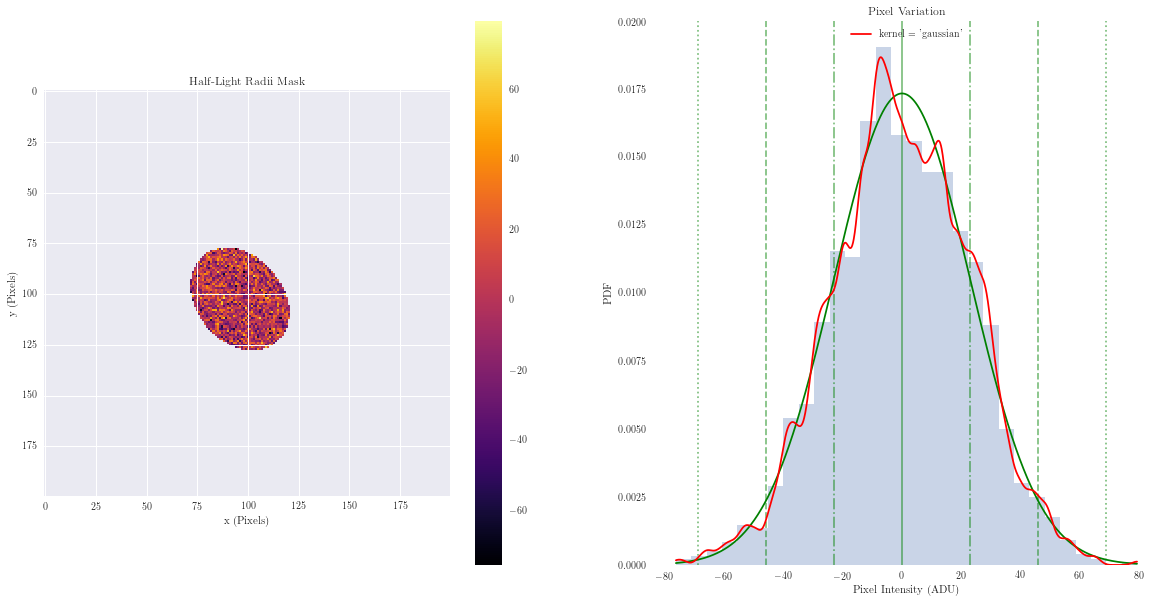

PU1006233


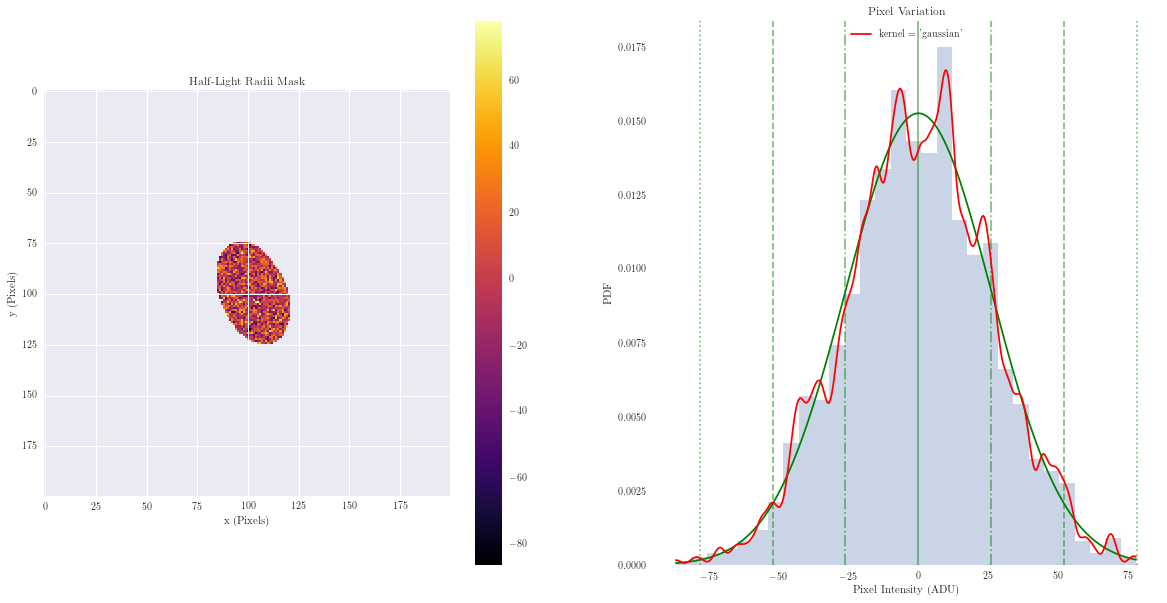

PU1006233


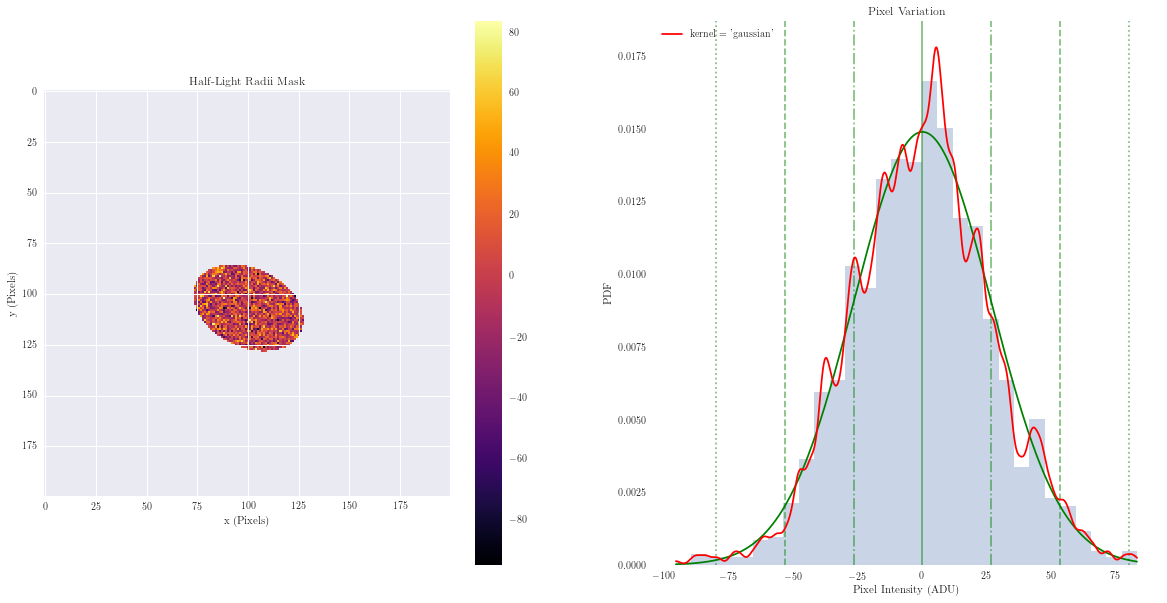

PU1217378


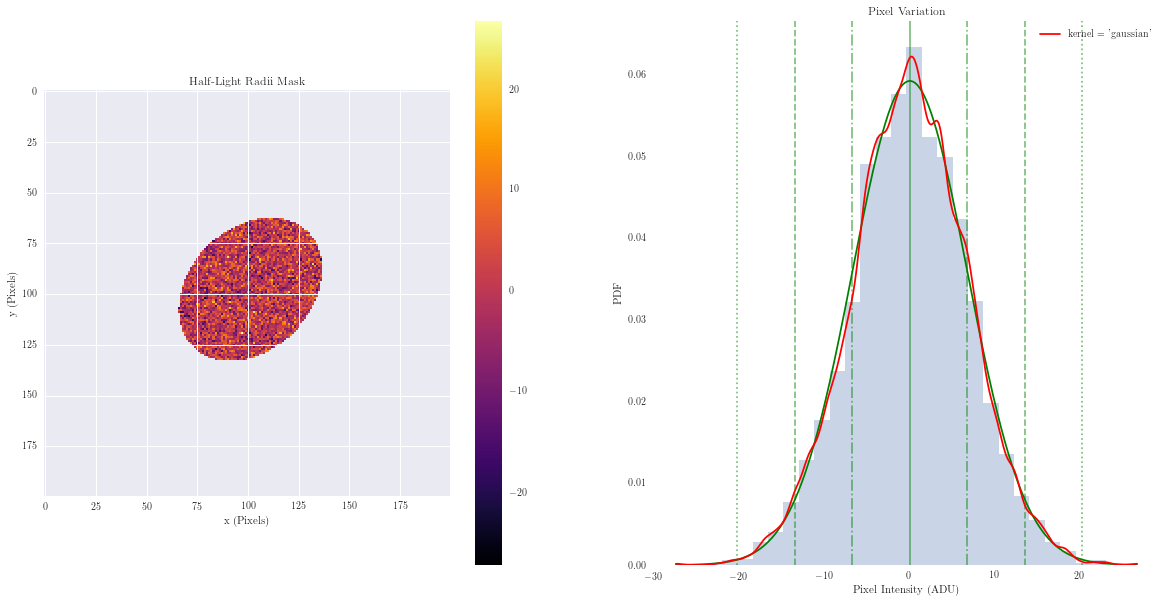

PU1217378


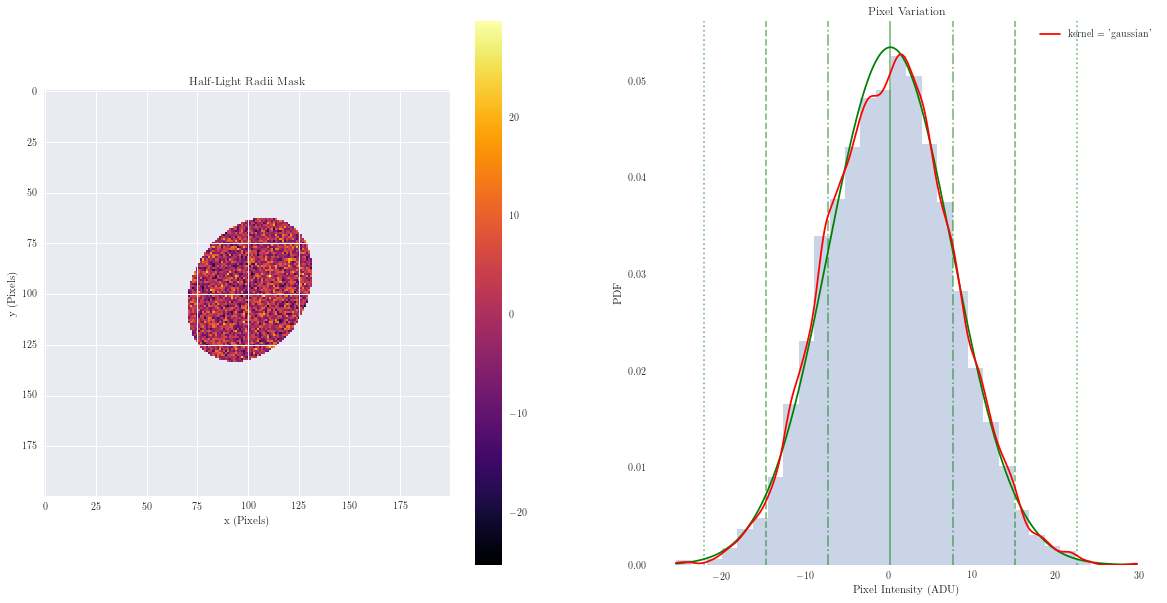

PU1217378


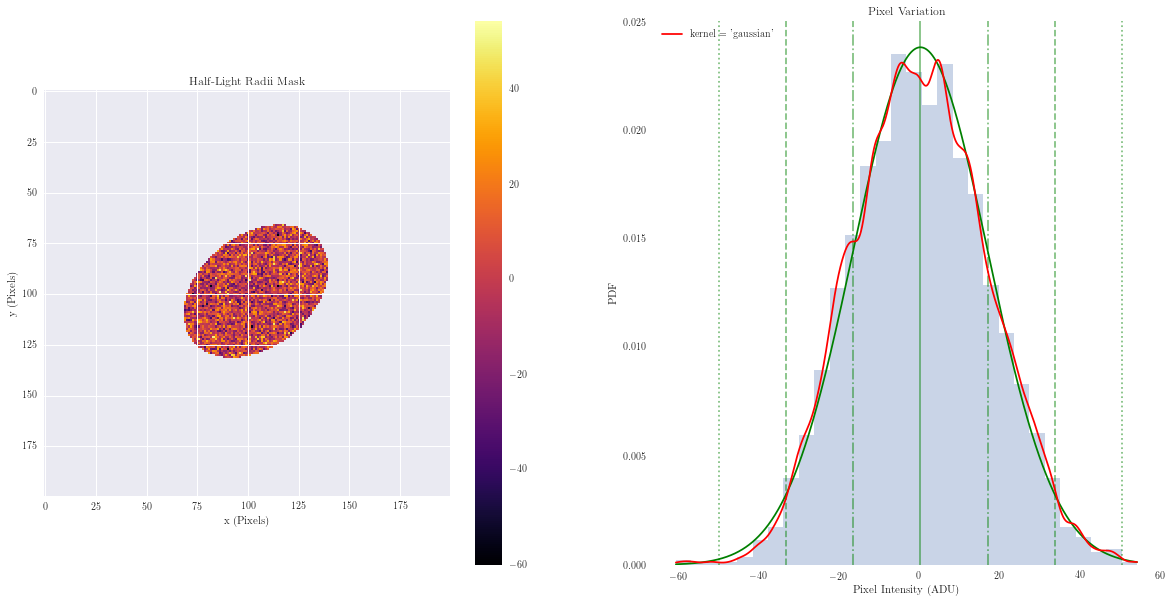

PU1221086


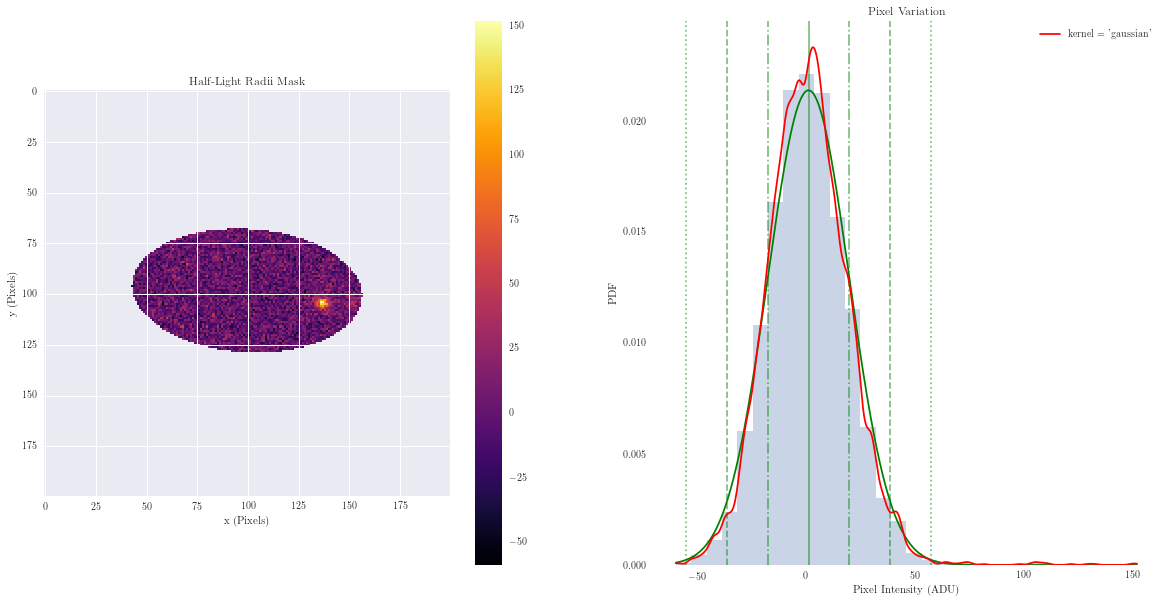

PU1224081


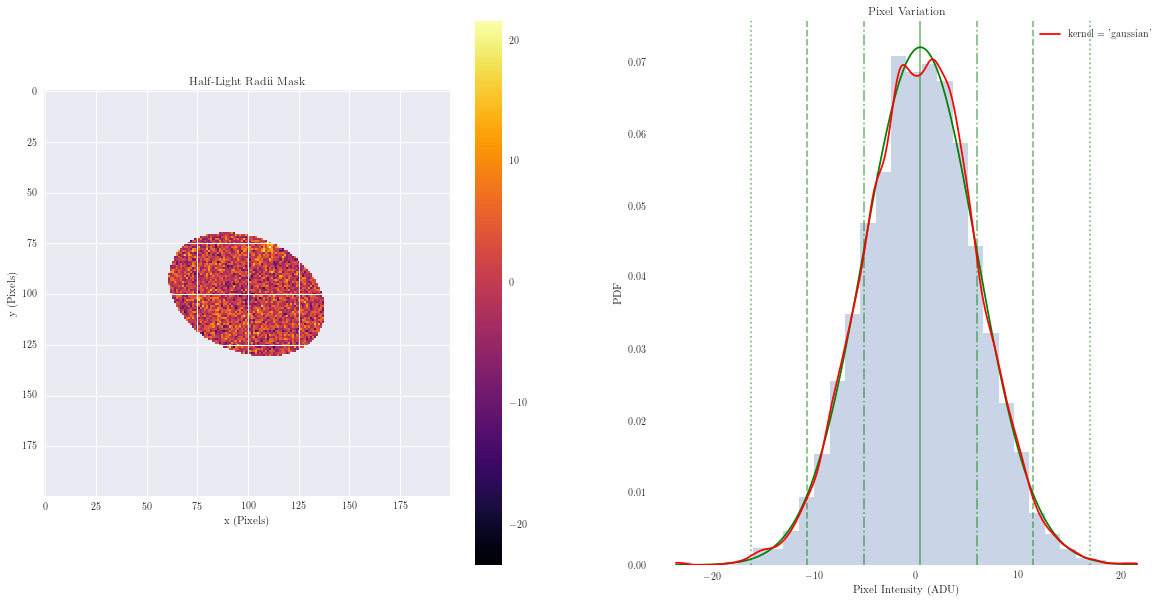

PU1224081


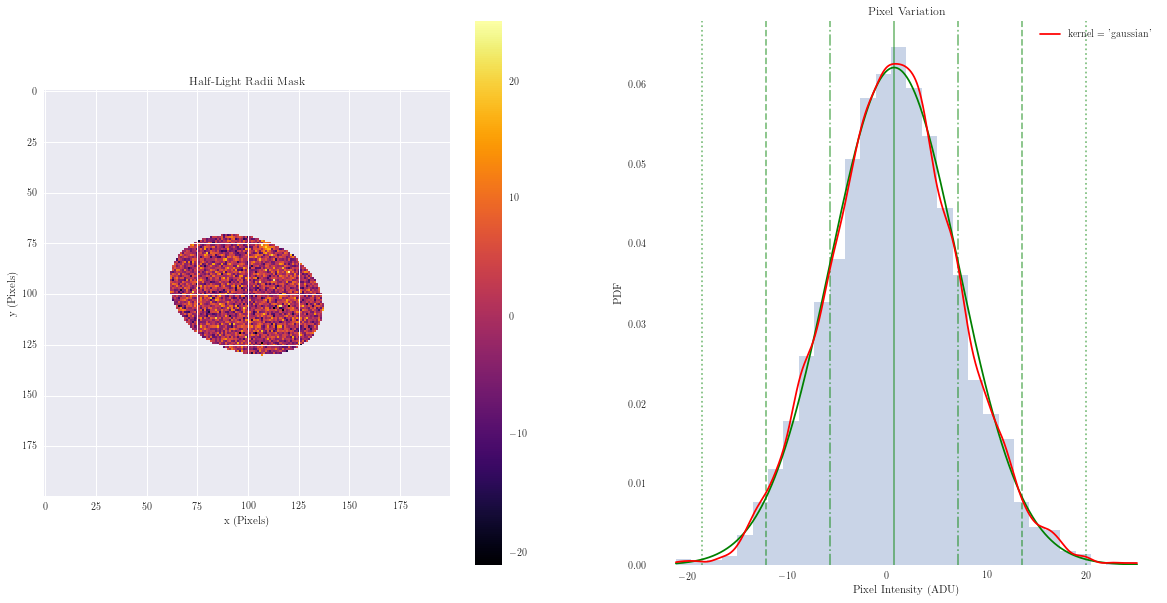

PU1224081


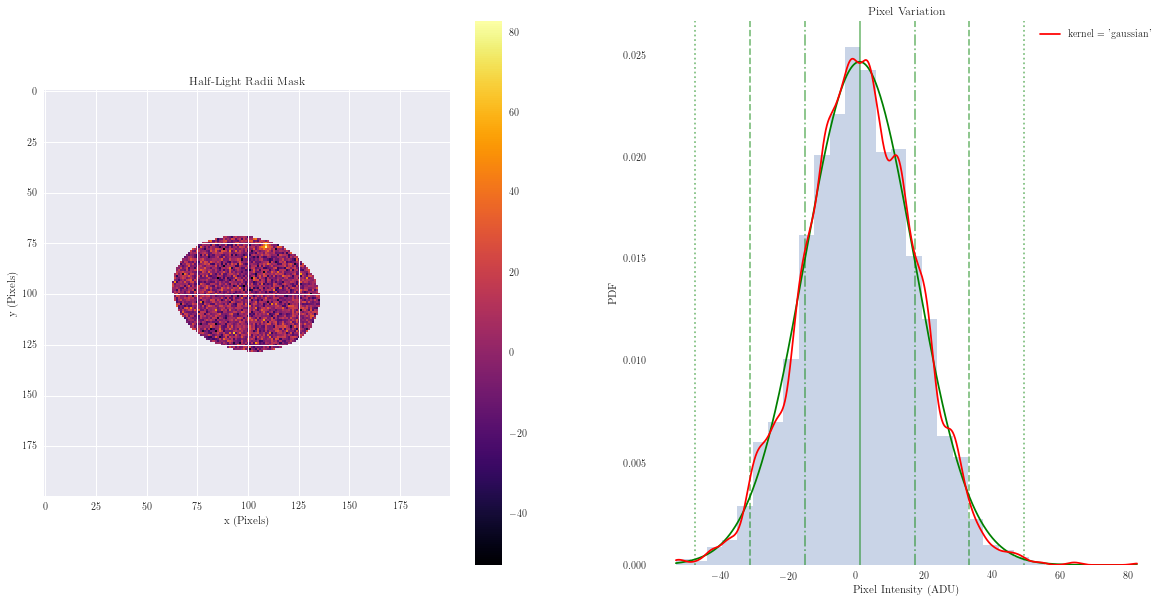

PU1251013


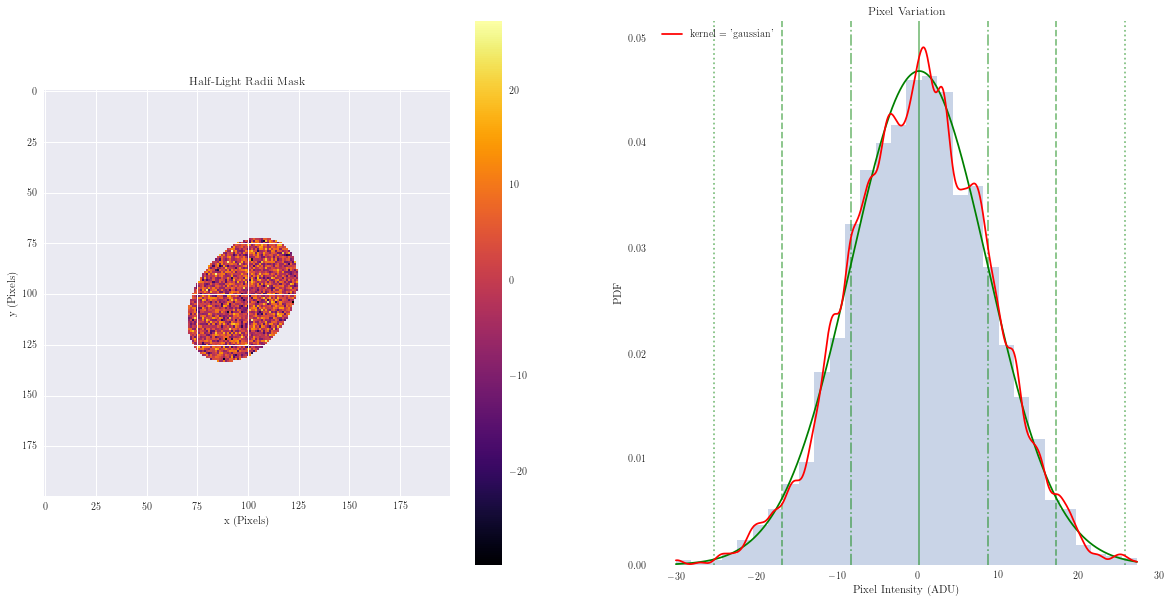

PU1251013


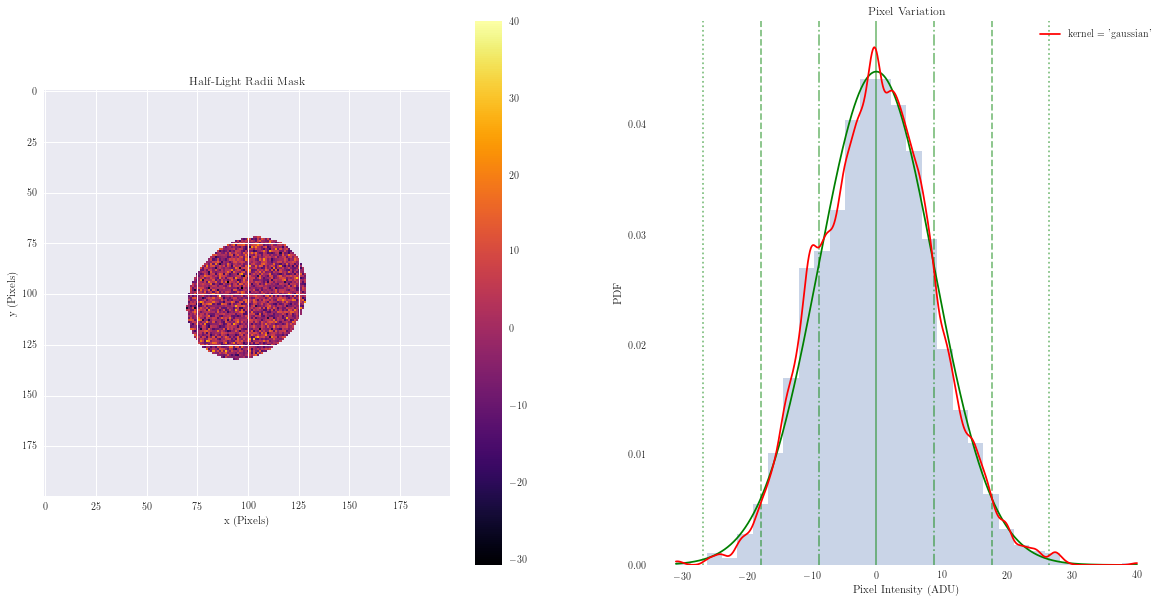

PU1251013


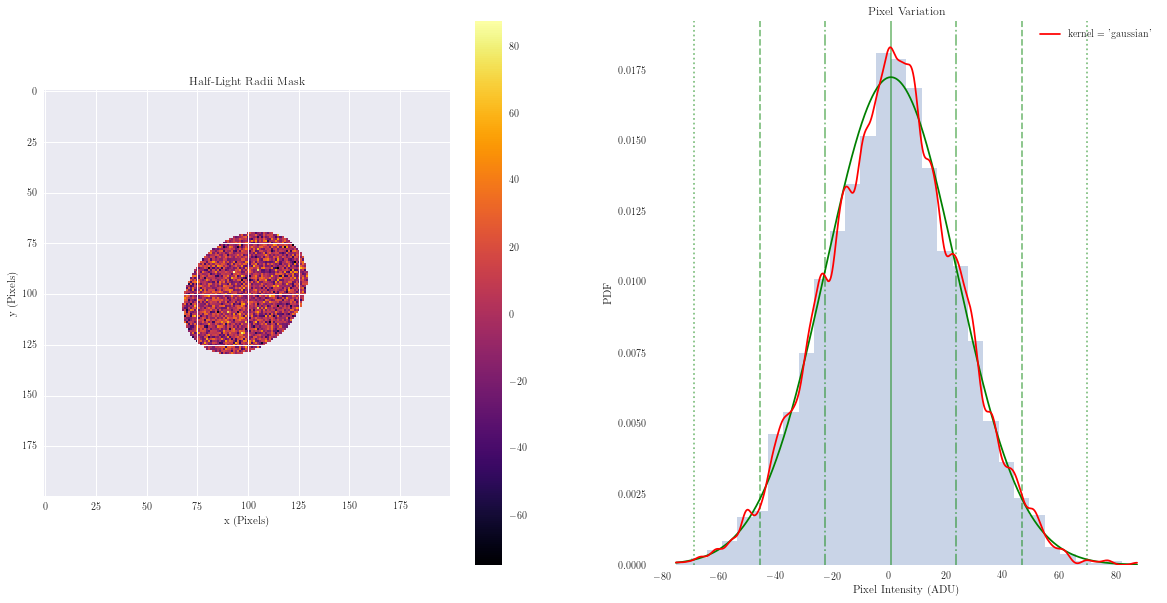

PU1253151


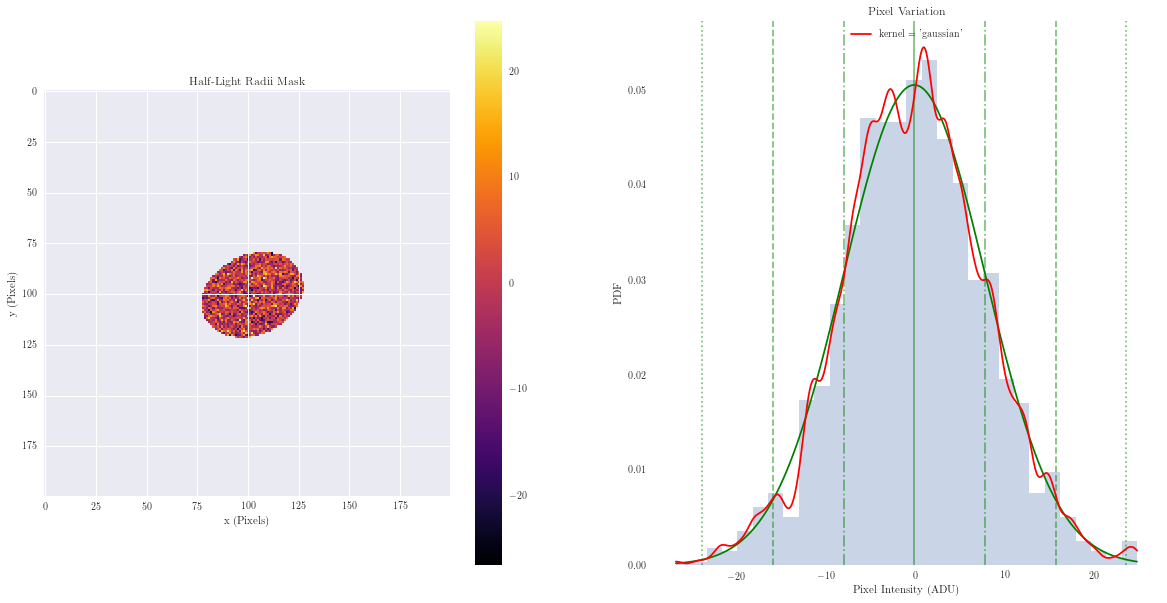

PU1253151


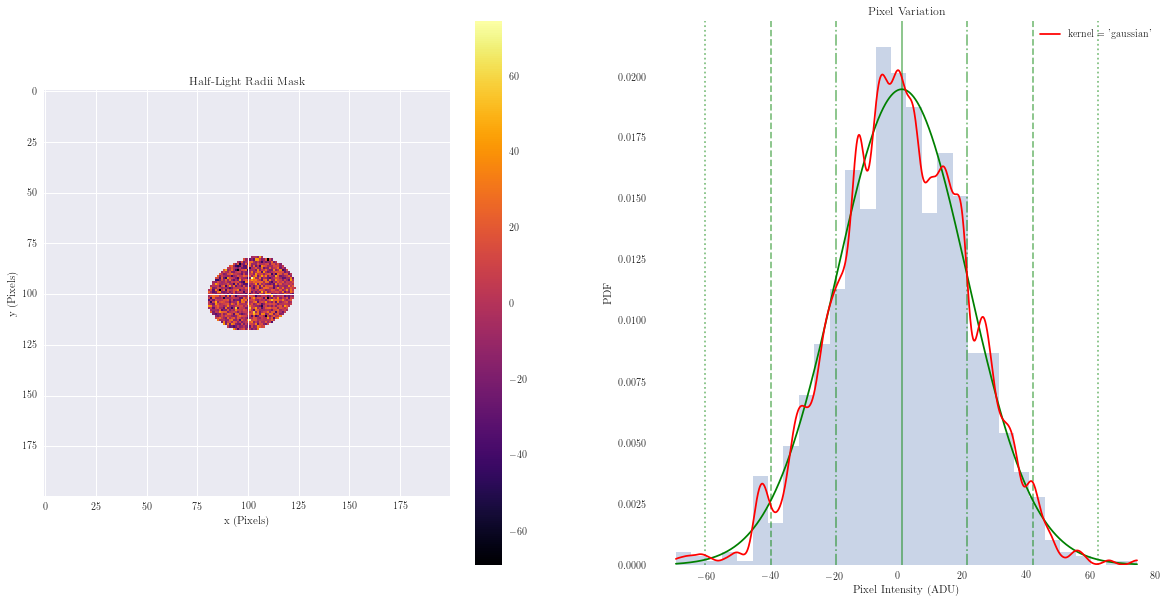

PU1257017


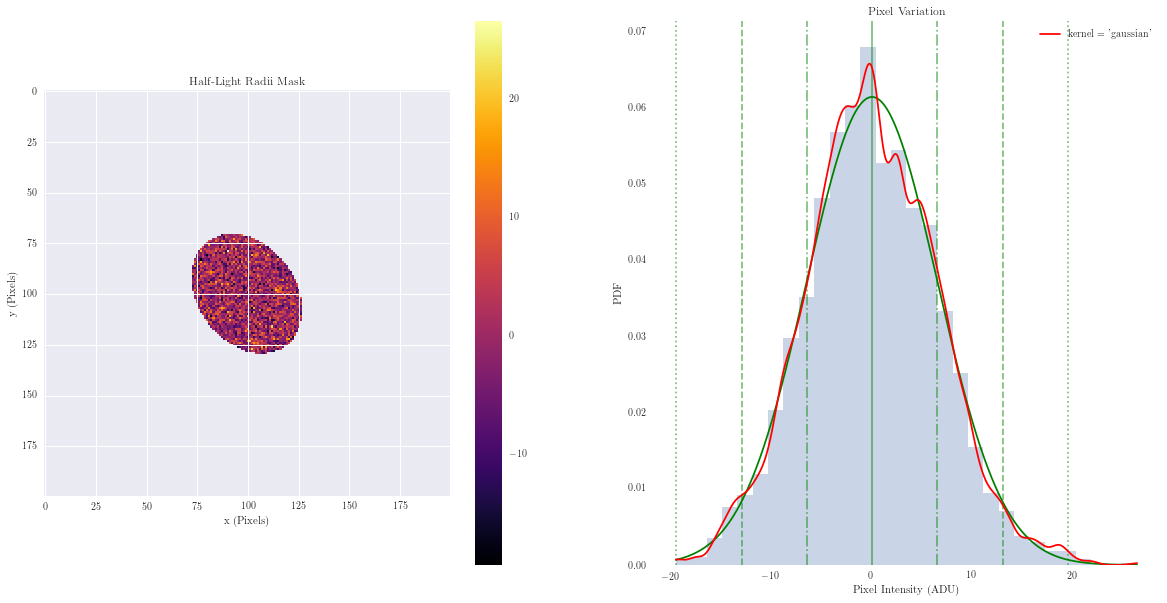

PU1257017


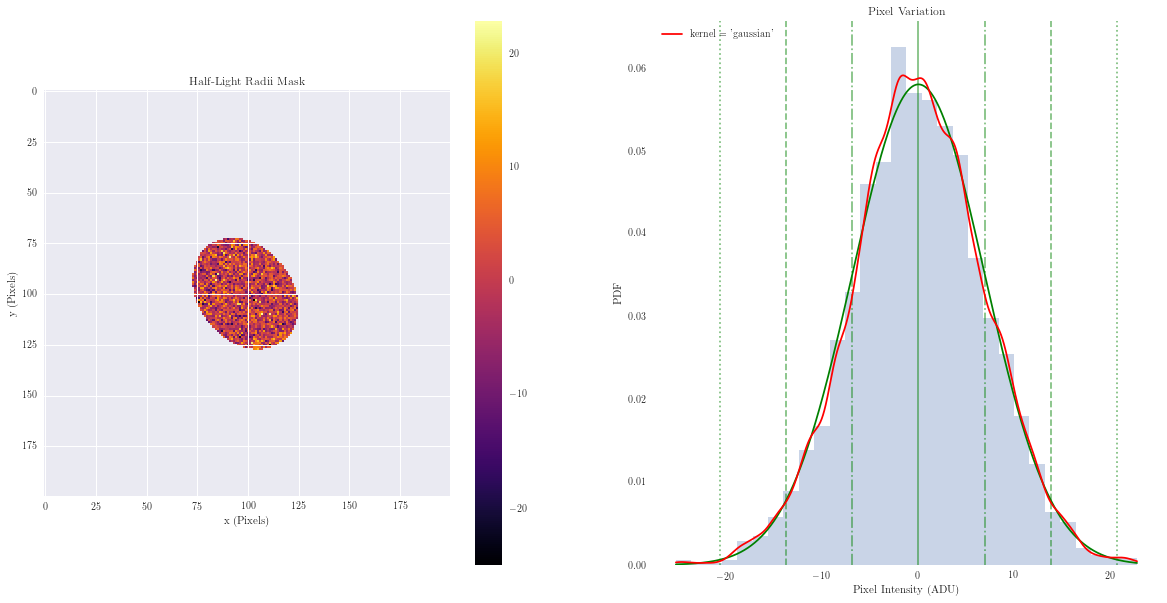

PU1257017


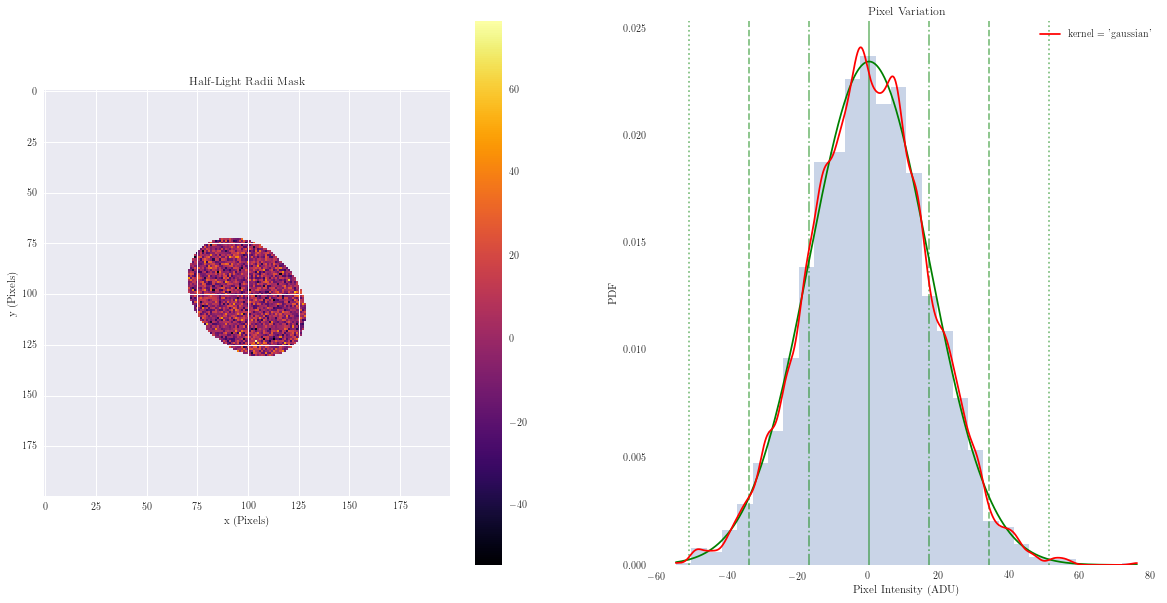

PU1258011


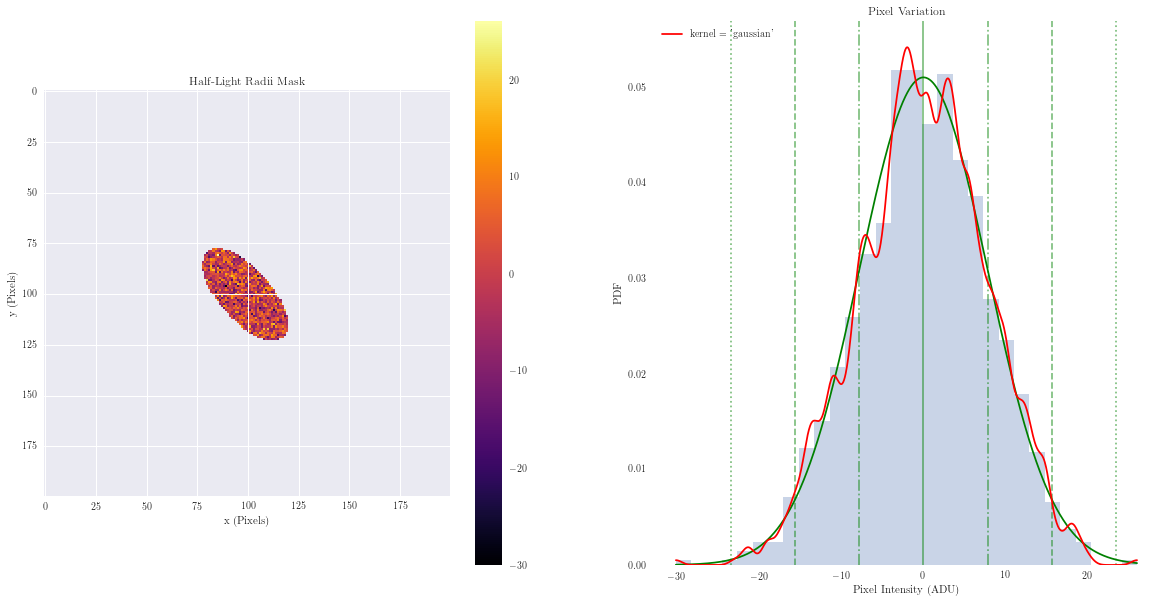

PU1258011


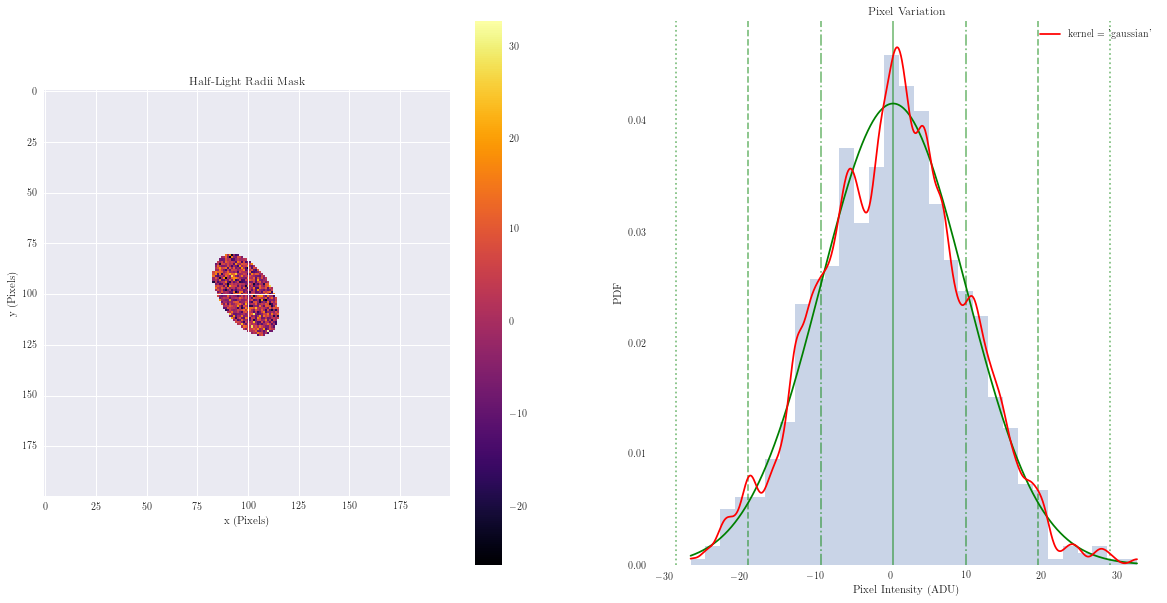

PU1258011


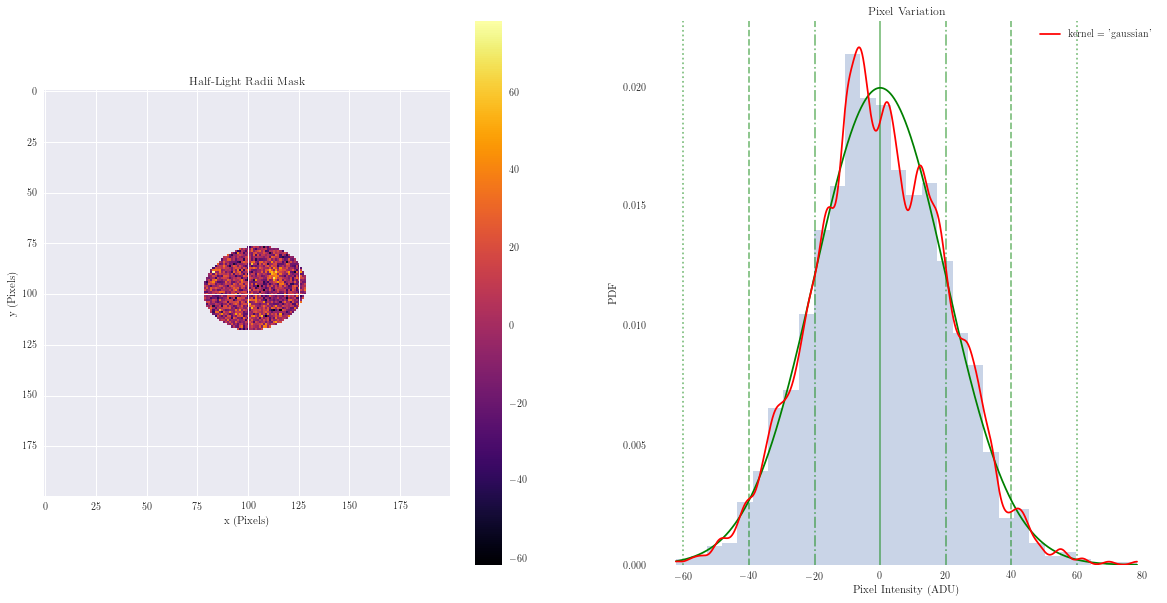

PU1301303


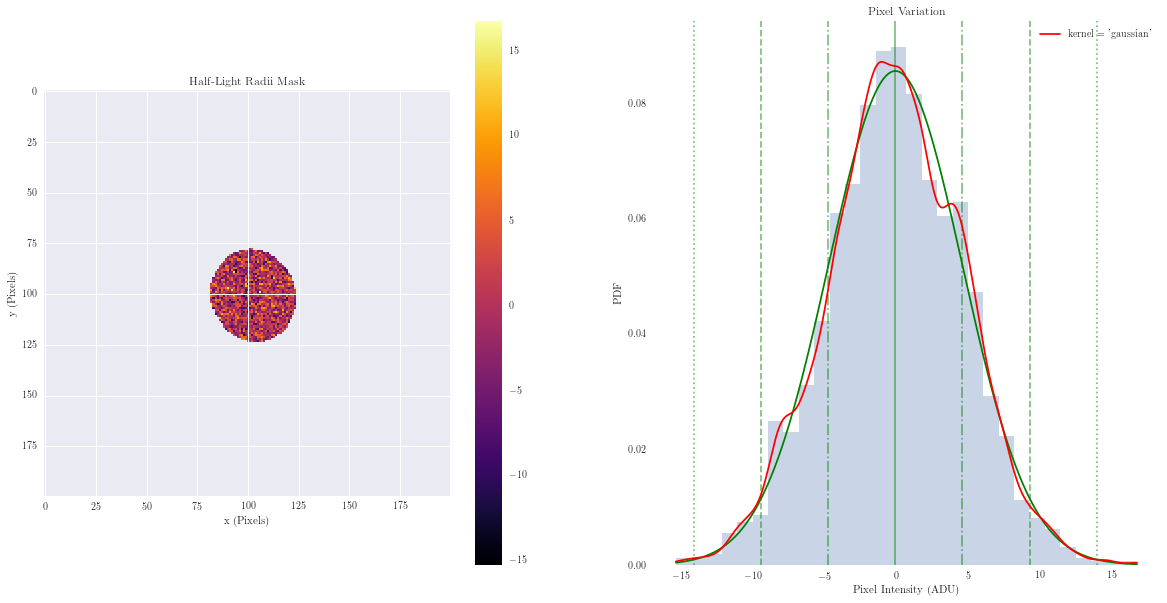

PU1301303


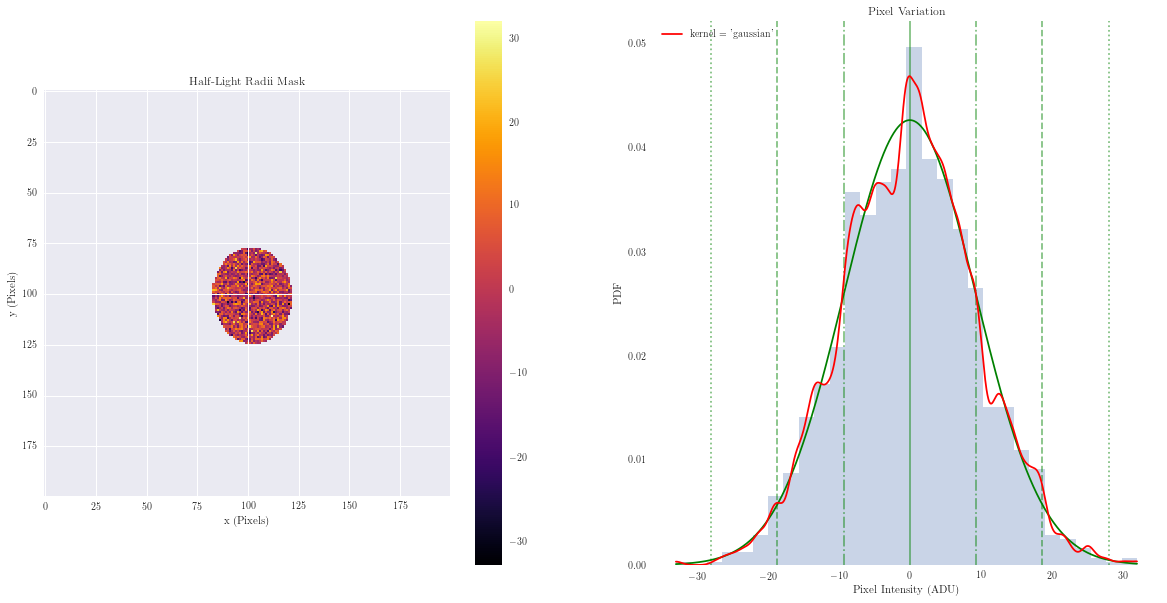

PU1301303


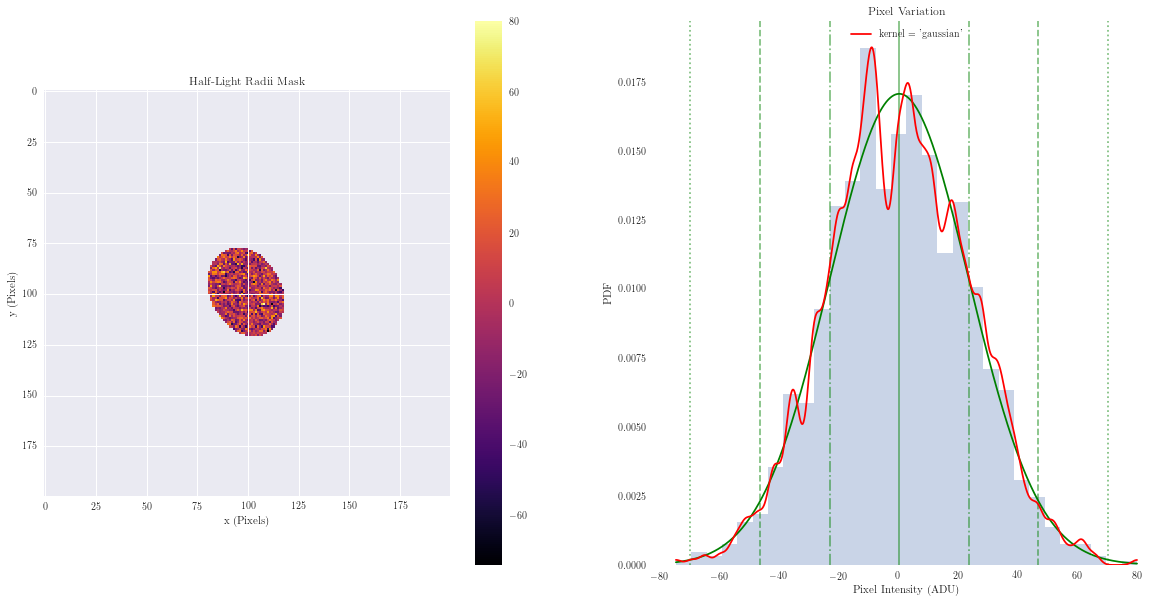

PU1301582


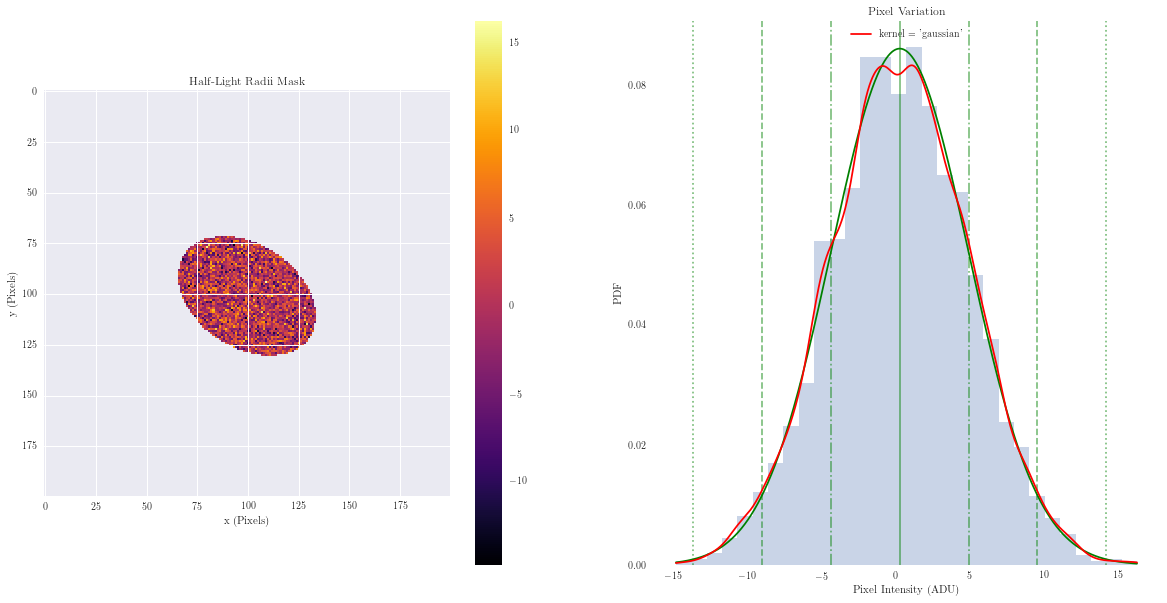

PU1301582


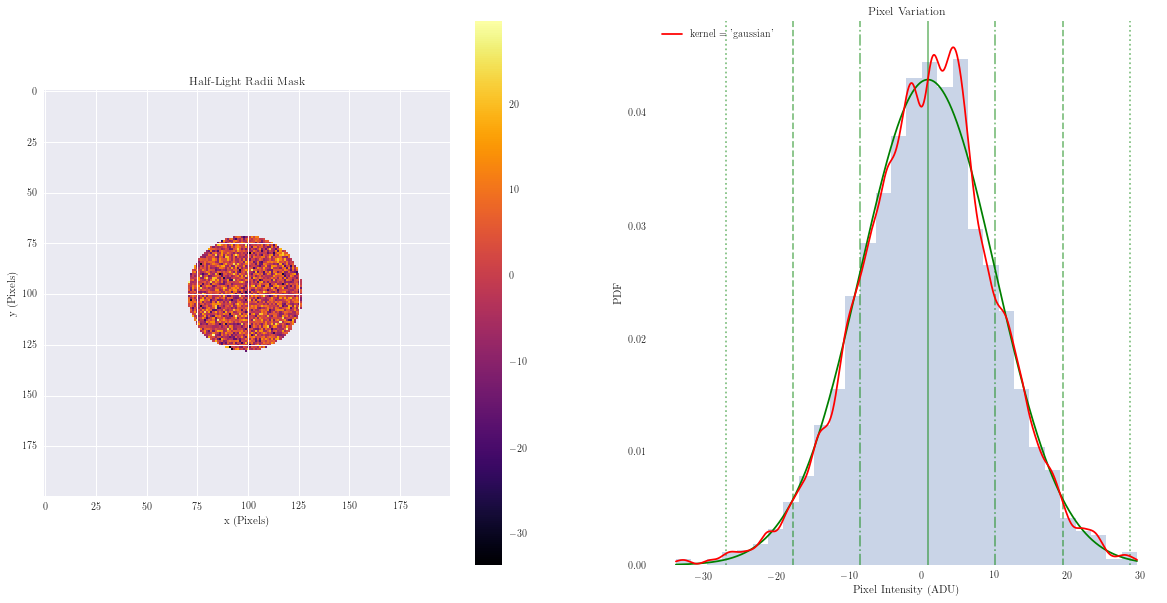

PU1301582


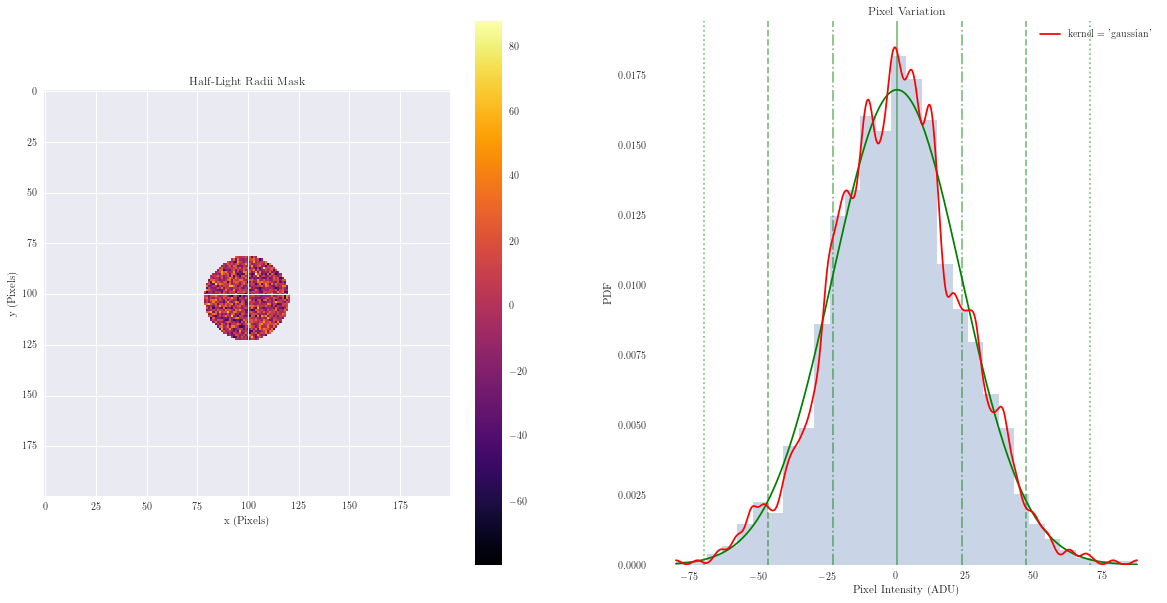

PU1302165


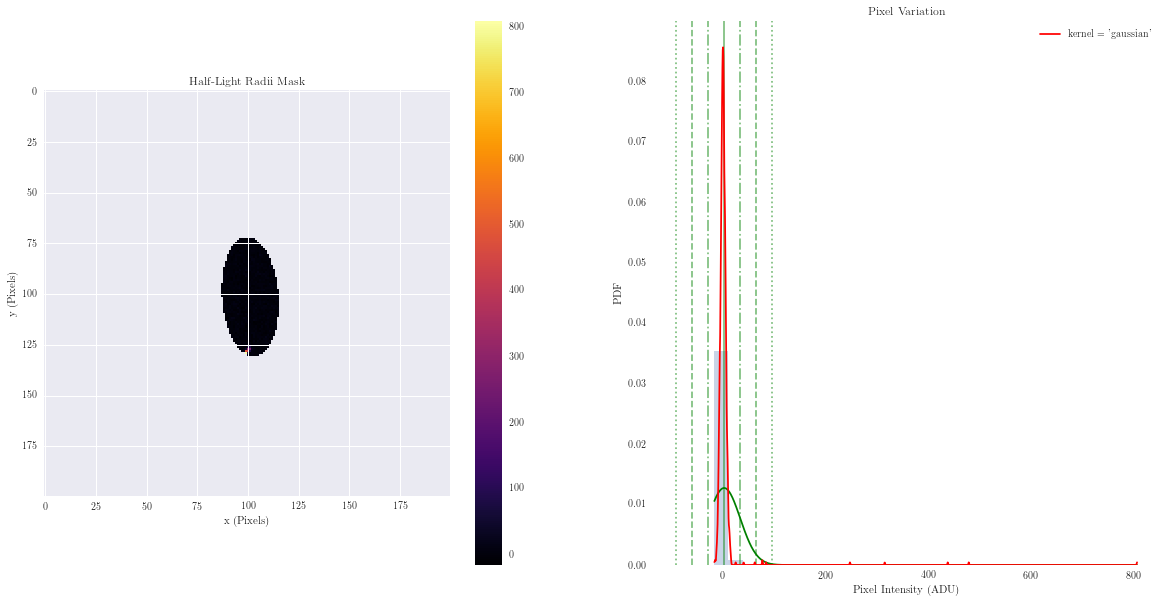

PU1302165


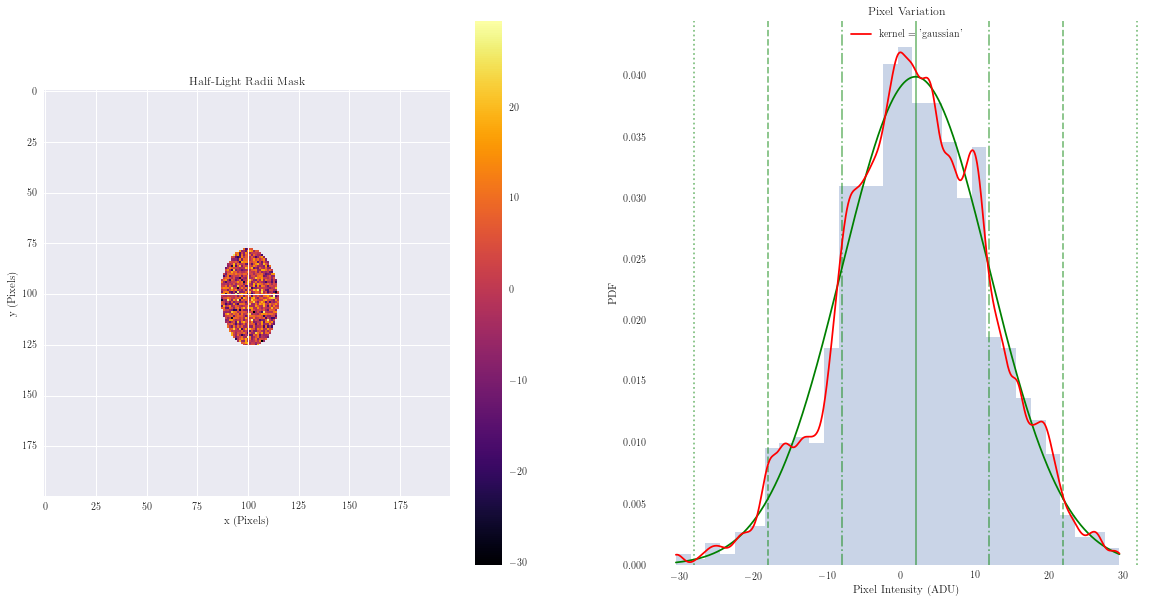

PU1302165


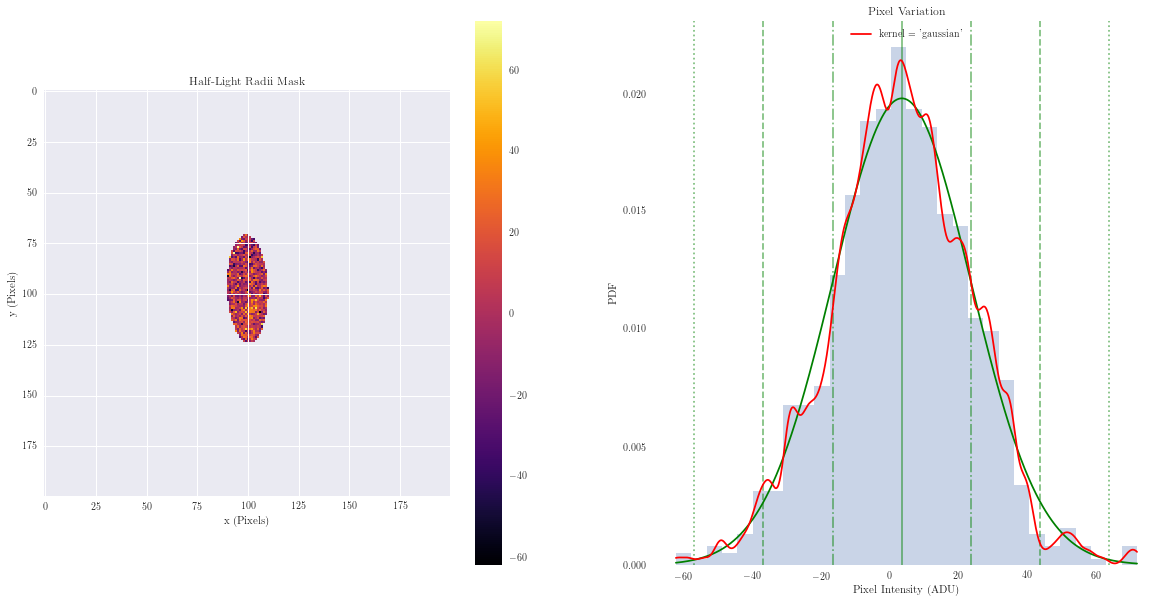

PU1304535


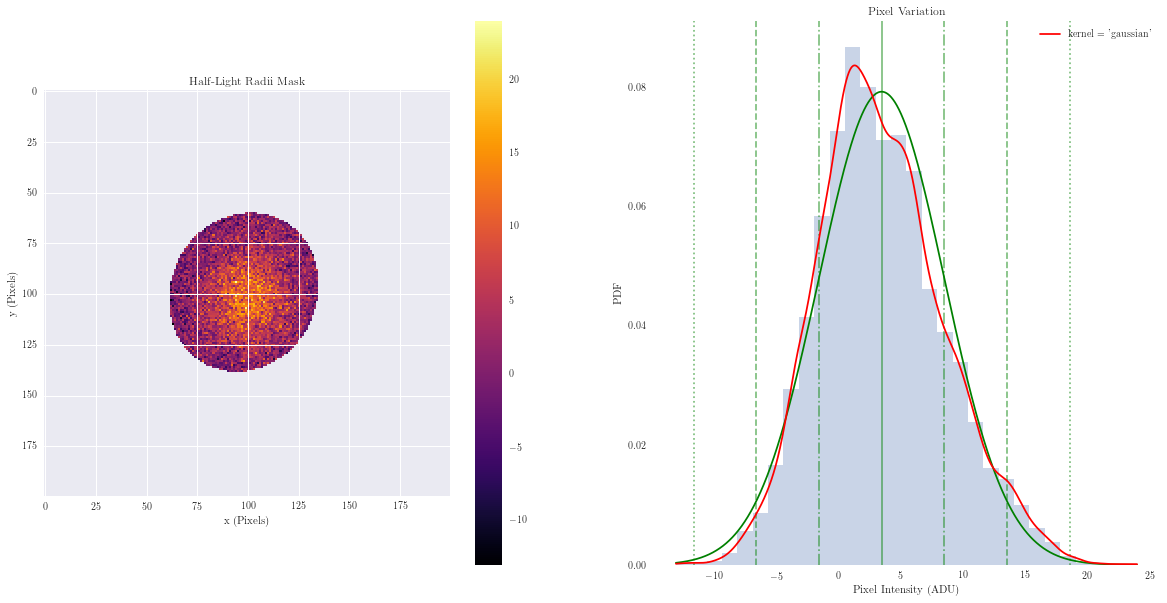

PU1304535


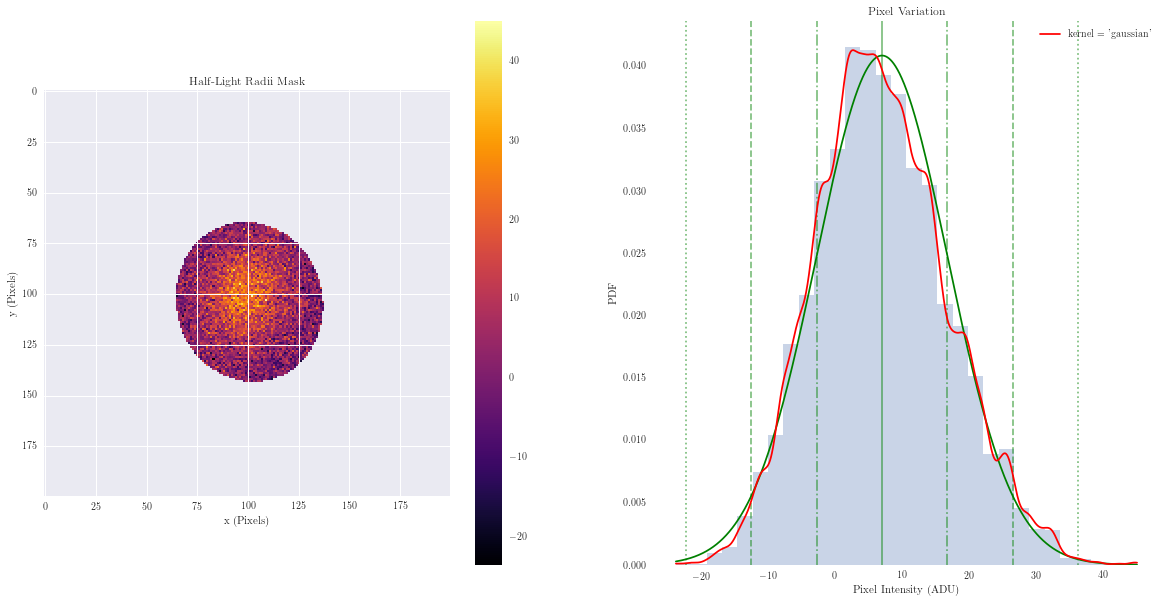

PU1304535


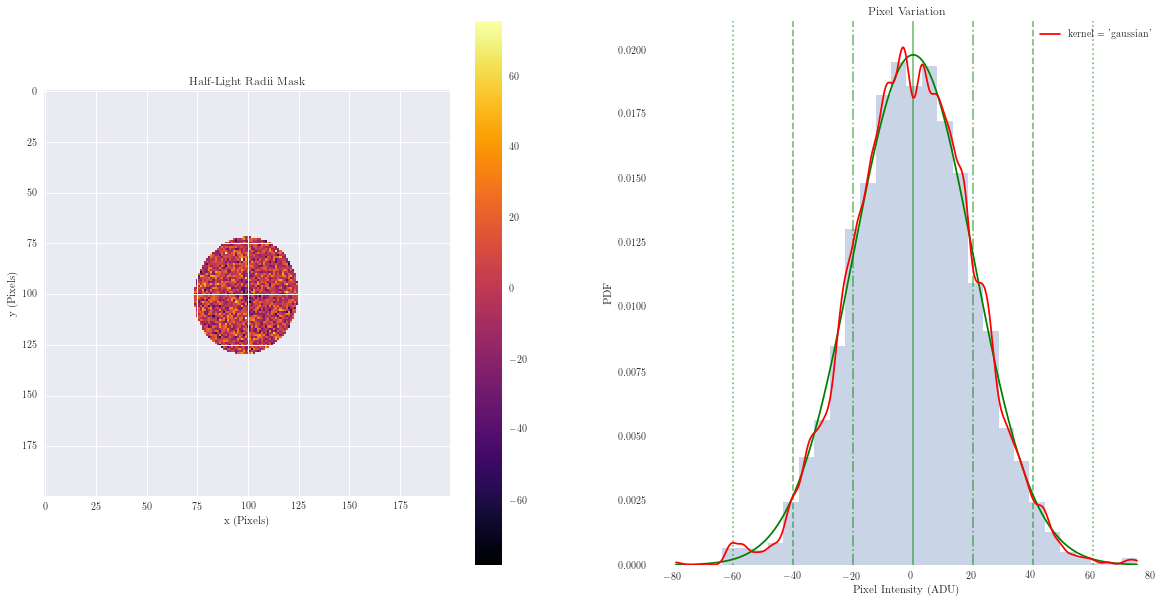

In [192]:
for obs in obs_list:
    
    if obs.UDG == 'PU1302165': obs.set_velocity(10150)
    elif obs.UDG == 'PU1257017': obs.set_velocity(6587)
    elif obs.UDG == 'PU1301304': obs.set_velocity(7051)
    elif obs.UDG == 'PU1201583': obs.set_velocity(np.nan)
    elif obs.UDG == 'PU1253151': obs.set_velocity(7316)
    elif obs.UDG == 'PU1258011': obs.set_velocity(7792)
    elif obs.UDG == 'PU0838589': obs.set_velocity(np.nan)
    elif obs.UDG == 'PU0914401': obs.set_velocity(6558)
    elif obs.UDG == 'PU1006233': obs.set_velocity(1202)
    elif obs.UDG == 'PU1217377': obs.set_velocity(526)
    elif obs.UDG == 'PU1221086': obs.set_velocity(1287)
    elif obs.UDG == 'PU1224081': obs.set_velocity(37)
    elif obs.UDG == 'PU1251013': obs.set_velocity(6159)
    elif obs.UDG == 'PU1304535': obs.set_velocity(7333)
    else: obs.set_velocity(np.nan)
    
    print(obs.UDG)
    
    data = fits.getdata(obs.get_res())
    mask = fits.getdata(obs.get_mask()) > 0.5
    
    obs.gal_mean = np.mean(data[mask])
    obs.gal_median = np.median(data[mask])
    obs.gal_stdev = np.std(data[mask])
    
    kde = plot_kde(data, mask=mask, band=obs.band, background=(obs.bkg_mean, obs.bkg_stdev), file=obs.get_basename() + kde_ext + png_file)
    obs.kde = kde

For each unique band for every target, I have plotted the mask-applied residual image (left) and its pixel-intensity histogram (right). The Gaussian kernel density estimate is plotted in red. The green curve is a Gaussian centered on the mean intensity of the mask-applied residual. The 1st, 2nd, and 3rd standard deviations of the Gaussian are denoted by dashed green lines. The choice of bandwidth varies with each band. The appropriate bandwidth choice is necessary to prevent over- and underfitting the distribution.

# Results

If the candidates were perfectly smooth objects (i.e. lacking features, structures, and clumpiness), subtracting a smooth model from the original image should remove the galaxy in its entirety. However, if structures remain, we will see it in the residual images. In the case where the model image is a composite of a uniform background (with no errors) and a near-exponential profile for the galaxy, the residual image of a featureless galaxy should have a mean of zero with Poisson noise from both the background and the galaxy. To first order, a featureless galaxy will have a pixel intensity variation modeled by $\mathcal{N}(\mu=0, \sigma)$, where $\sigma$ is standard deviation of the mask-applied residual image.

### Mean Square Error
The mean square error (MSE) measures the average squared deviation from the actual and predicted values, such that
<center> $\mathrm{MSE} = \frac{1}{n} \sum\limits_{i=1}^N \left(Y_i - \widehat{Y}_i \right)^2$ </center>.

The assume that the true distribution is the one estimated by Gaussian KDE. The predicted distribution is determined by theory. I use the MSE to quantify the amount of pixel variation observed in each of our targets.

In [210]:
udg_list = [obs for obs in obs_list if obs.velocity > 6000]
not_list = [obs for obs in obs_list if obs.velocity < 6000]

udg_g = [obs for obs in udg_list if obs.band == 'g']
not_g = [obs for obs in not_list if obs.band == 'g']

udg_r = [obs for obs in udg_list if obs.band == 'r']
not_r = [obs for obs in not_list if obs.band == 'r']

udg_z = [obs for obs in udg_list if obs.band == 'z']
not_z = [obs for obs in not_list if obs.band == 'z']

In [259]:
def get_var_vel(sigma=5, verbose=False): 
    
    x,y = obs.kde
    gauss1 = norm.pdf(x, 0, obs.gal_stdev)

    if verbose:
        print(obs.UDG, obs.band,
            '\n\tBackground Mean: ', obs.bkg_mean,
            '\n\tBackground StDev:', obs.bkg_stdev,
            '\n\tGalaxy Mean:     ', obs.gal_mean,
            '\n\tGalaxy Median:   ', obs.gal_median,
            '\n\tGalaxy StDev:    ', obs.gal_stdev,
            '\n\tRecessional Vel: ', obs.velocity)
        
    sq_err = np.sum(((y-gauss1)**2)) / y.size

    return sq_err, obs.velocity

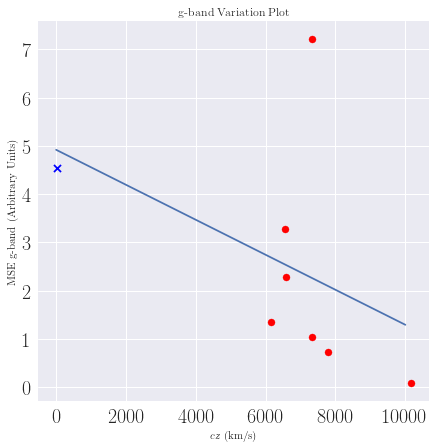

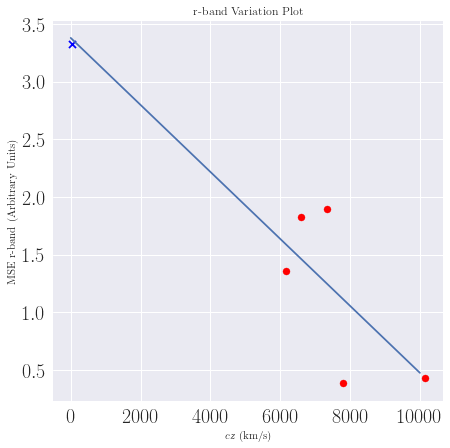

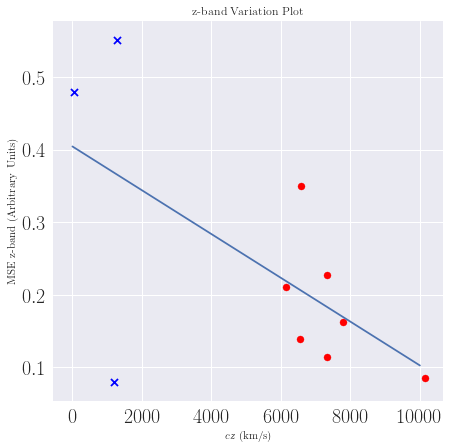

In [278]:
plt.rcParams.update({'font.size': 50})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')

plt.title("g-band Variation Plot")
plt.xlabel(r"$cz$ (km/s)")
plt.ylabel(r"MSE g-band (Arbitrary Units)")

var_list=[]
vel_list=[]
vel_range = np.linspace(0,10000,10)

for obs in udg_g:
    var, vel = get_var_vel()
    plt.scatter(vel, var, color='r', s=50, marker='o', label="True UDG")
    var_list.append(var)
    vel_list.append(vel)
for obs in not_g:
    var, vel = get_var_vel()
    plt.scatter(vel, var, color='b', s=50, marker='x', label="Spurious Source")
    var_list.append(var)
    vel_list.append(vel)

m,b = np.polyfit(vel_list, var_list, 1)
pred = m * vel_range + b
plt.plot(vel_range,pred)
plt.show()



fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')

plt.title("r-band Variation Plot")
plt.xlabel(r"$cz$ (km/s)")
plt.ylabel(r"MSE r-band (Arbitrary Units)")

var_list=[]
vel_list=[]

for obs in udg_r:
    var, vel = get_var_vel()
    plt.scatter(vel, var, color='r', s=50, marker='o', label="True UDG")
    var_list.append(var)
    vel_list.append(vel)
for obs in not_r:
    var, vel = get_var_vel()
    plt.scatter(vel, var, color='b', s=50, marker='x', label="Spurious Source")
    var_list.append(var)
    vel_list.append(vel)

m,b = np.polyfit(vel_list, var_list, 1)
pred = m * vel_range + b
plt.plot(vel_range,pred)
plt.show()


fig = plt.figure(figsize=(7,7))
fig.patch.set_facecolor('white')

var_list=[]
vel_list=[]

plt.title("z-band Variation Plot")
plt.xlabel(r"$cz$ (km/s)")
plt.ylabel(r"MSE z-band (Arbitrary Units)")

for obs in udg_z:
    var, vel = get_var_vel()
    plt.scatter(vel, var, color='r', s=50, marker='o', label="True UDG")
    var_list.append(var)
    vel_list.append(vel)
for obs in not_z:
    var, vel = get_var_vel()
    plt.scatter(vel, var, color='b', s=50, marker='x', label="Spurious Source")
    var_list.append(var)
    vel_list.append(vel)

m,b = np.polyfit(vel_list, var_list, 1)
pred = m * vel_range + b
plt.plot(vel_range,pred)
plt.show()

# Discussion & Future Work

The plots above show the distribution of MSE given each wavelength (g-, r-, z-bands, respectively) for the true UDGs (red dots) and the spurious sources (blue crossmarks) for which we've attained spectroscopic redshifts. We must be careful when interpreting these results due to the lack of spurious sources in our data set and due to the high scatter around the best-fit line. However, in general, our contaminants have higher MSEs compared to the UDGs in our sample. This work shows promising preliminary results, suggesting that pixel variations can be used to determine the likelihood of the candidate being a true UDG.

In the future, I would like to implement the following:
1. Use cross-validation to more rigorously determine the appropriate bandwidth of KDE.
2. Acquire more LSB objects with spectroscopic redshifts to better constrain the fit.
3. Implement support vector machines to determine the thresholds separating UDGs from contaminants, given a the angular size of the object.